In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Virtual KITTI Dataset Download

In [ ]:
!pip install --upgrade dataset-tools

In [ ]:
# Change working directory to your target folder
import os
os.makedirs('/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1', exist_ok=True)
os.chdir('/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1')

# -------------------------------------------------------------
# Download and extract Virtual KITTI 1.3.1 dataset archives
# -------------------------------------------------------------

# The required archive files for RGB, depth GT
files = [
    'vkitti_1.3.1_rgb.tar',
    'vkitti_1.3.1_depthgt.tar',
    'vkitti_1.3.1_extrinsicsgt.tar.gz'
]

# Base URL hosting the dataset files
base_url = 'http://download.europe.naverlabs.com/virtual-kitti-1.3.1'

# Loop through each file, download, and extract it
for f in files:
    print(f"Downloading {f} ...")

    # '-c' enables continue mode to resume partial downloads if interrupted
    os.system(f"wget -c {base_url}/{f}")

    print(f"Extracting {f} ...")

    # Extract .tar.gz or .tar depending on file extension
    if f.endswith('.tar.gz'):
        os.system(f"tar -xvzf {f}")   # Extract gzip-compressed tar
    elif f.endswith('.tar'):
        os.system(f"tar -xvf {f}")    # Extract uncompressed tar
    else:
        # Safety check in case unexpected file types appear
        print(f"Unknown archive format for {f}, skipping extraction.")


print("All done! Dataset downloaded and extracted.")

Extracting vkitti_1.3.1_rgb.tar ...
Extracting vkitti_1.3.1_depthgt.tar ...
Extracting vkitti_1.3.1_extrinsicsgt.tar.gz ...
All done! Dataset downloaded and extracted.


Found 447 depth files. Sample: ['00000.png', '00001.png', '00002.png', '00003.png', '00004.png']
Depth image shape: (375, 1242), dtype: uint16
Depth min: 394, max: 65535


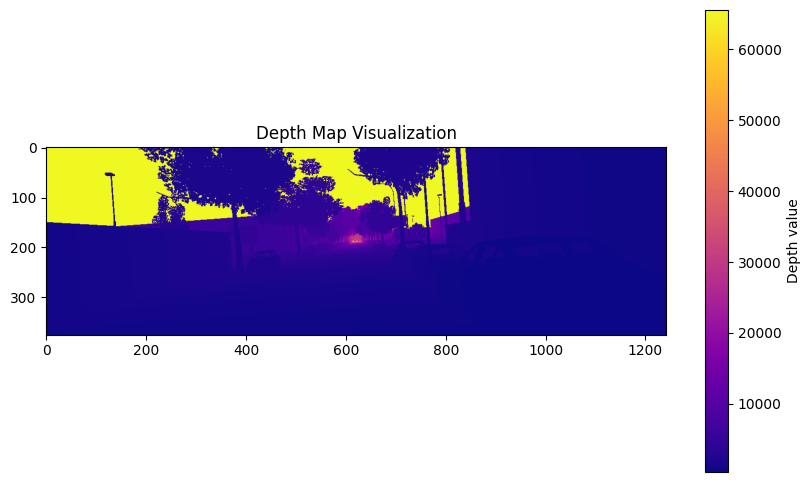

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Folder containing Virtual KITTI depth ground-truth images
depth_gt_dir = '/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_depthgt/0001/clone'

# List some files in the folder
depth_files = sorted(os.listdir(depth_gt_dir))
print(f"Found {len(depth_files)} depth files. Sample:", depth_files[:5])

# cv2.IMREAD_UNCHANGED ensures the PNG is loaded exactly as stored (16-bit).
# Depth PNGs in Virtual KITTI are stored as uint16 representing depth * 100.
depth_path = os.path.join(depth_gt_dir, depth_files[0])
depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

print(f"Depth image shape: {depth_img.shape}, dtype: {depth_img.dtype}")
print(f"Depth min: {np.min(depth_img)}, max: {np.max(depth_img)}")

# Plot the raw depth map. Since it is 16-bit, we apply a colormap
plt.figure(figsize=(10,6))
plt.title('Depth Map Visualization')
plt.imshow(depth_img, cmap='plasma')
plt.colorbar(label='Depth value')
plt.show()

In [ ]:
import numpy as np

# Virtual KITTI depth: 1 unit = 1 cm
depth_m = depth_img.astype(np.float32) / 100.0

# invalid pixels = value == 65535 (far plane)
valid_mask = depth_img < 65535

valid_depths = depth_m[valid_mask]

print(f"Valid depth range (meters): min={valid_depths.min():.3f}, max={valid_depths.max():.3f}")
print(f"Number of valid pixels: {valid_mask.sum()} / {depth_img.size}")


Valid depth range (meters): min=3.940, max=517.000
Number of valid pixels: 402345 / 465750


## Image Preprocessing

In [ ]:
import glob
import os

# Root directories for Virtual KITTI RGB images and depth ground truth
RGB_ROOT   = "/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_rgb"
DEPTH_ROOT = "/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_depthgt"

def get_all_pairs():
    """
    Traverse the Virtual KITTI directory structure and return a list of
    (rgb_path, depth_path) pairs.

    Directory format:
        vkitti_1.3.1_rgb/<scene>/<variant>/*.png
        vkitti_1.3.1_depthgt/<scene>/<variant>/*.png

    The function ensures that for each scene and variant, RGB and depth
    images match 1-to-1 by filename ordering.
    """
    all_pairs = []

    # ------------------------------------------------------------
    # List all scenes (e.g., '0001', '0002', ..., '0006')
    # ------------------------------------------------------------
    scenes = sorted([
        d for d in os.listdir(RGB_ROOT)
        if os.path.isdir(os.path.join(RGB_ROOT, d))
    ])

    for scene in scenes:
        scene_rgb_path = os.path.join(RGB_ROOT, scene)

        # ------------------------------------------------------------
        # Inside each scene, list all camera variants and conditions:
        #     clone, 15-deg-left, 15-deg-right, fog, etc.
        # ------------------------------------------------------------
        variants = sorted([
            v for v in os.listdir(scene_rgb_path)
            if os.path.isdir(os.path.join(scene_rgb_path, v))
        ])

        for variant in variants:

            # Glob all PNGs for this scene/variant
            rgb_glob   = f"{RGB_ROOT}/{scene}/{variant}/*.png"
            depth_glob = f"{DEPTH_ROOT}/{scene}/{variant}/*.png"

            rgb_paths   = sorted(glob.glob(rgb_glob))
            depth_paths = sorted(glob.glob(depth_glob))

            # -------------------------------------------------
            # Ensure matching number of RGB and depth frames
            # -------------------------------------------------
            if len(rgb_paths) != len(depth_paths):
                print(f"⚠️ Mismatch in Scene {scene}, Variant {variant}: "
                      f"{len(rgb_paths)} RGB vs {len(depth_paths)} depth")
                continue

            # Add all (RGB, depth) pairs to list
            all_pairs.extend(list(zip(rgb_paths, depth_paths)))

    return all_pairs


# Retrieve all matching RGB–depth image pairs
pairs = get_all_pairs()

print("Total image pairs:", len(pairs))
pairs[:5]   # Preview first 5 pairs

Total image pairs: 21260


[('/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_rgb/0001/15-deg-left/00000.png',
  '/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_depthgt/0001/15-deg-left/00000.png'),
 ('/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_rgb/0001/15-deg-left/00001.png',
  '/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_depthgt/0001/15-deg-left/00001.png'),
 ('/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_rgb/0001/15-deg-left/00002.png',
  '/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_depthgt/0001/15-deg-left/00002.png'),
 ('/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_rgb/0001/15-deg-left/00003.png',
  '/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_depthgt/0001/15-deg-left/00003.png'),
 ('/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_rgb/0

In [ ]:
import os
import glob
import cv2
import numpy as np

# Root directories for RGB images and depth ground truth
RGB_ROOT   = "/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_rgb"
DEPTH_ROOT = "/content/drive/MyDrive/kitti/EigenNetwork_2014/VirtualKITTI_v1/vkitti_1.3.1_depthgt"

# Model input and output dimensions
RGB_W, RGB_H = 576, 172     # Input size expected by the model (width × height)
D_W, D_H     = 142, 27      # Output depth map size from the model (width × height)


def load_all_pairs():
    """
    Scan through all scenes and camera variants, returning a list of paired
    file paths for RGB and depth images.

    Returns:
        pairs (list of tuples): List of (rgb_path, depth_path) pairs
    """
    pairs = []
    # List all scene directories in RGB root
    scenes = sorted(os.listdir(RGB_ROOT))

    for scene in scenes:
        scene_rgb_path = f"{RGB_ROOT}/{scene}"
        if not os.path.isdir(scene_rgb_path):
            # Skip if not a directory
            continue

        # List all variants inside each scene (e.g., 'clone', '15-deg-left', etc.)
        variants = sorted(os.listdir(scene_rgb_path))

        for variant in variants:
            # Construct glob patterns to find all PNG images for RGB and depth
            rgb_glob = f"{RGB_ROOT}/{scene}/{variant}/*.png"
            depth_glob = f"{DEPTH_ROOT}/{scene}/{variant}/*.png"

            # Get sorted lists of all RGB and depth file paths
            rgb_paths = sorted(glob.glob(rgb_glob))
            depth_paths = sorted(glob.glob(depth_glob))

            # Check for matching number of RGB and depth images
            if len(rgb_paths) != len(depth_paths):
                print(f"⚠️ Mismatch in {scene}/{variant}, skipping...")
                continue

            # Extend the pairs list with tuples of matching (rgb_path, depth_path)
            pairs.extend(list(zip(rgb_paths, depth_paths)))

    return pairs


def load_and_resize_rgb(path):
    """
    Load an RGB image from disk, convert color format, resize to model input size,
    and normalize pixel values to [0,1].

    Args:
        path (str): Path to the RGB image file.

    Returns:
        img (numpy.ndarray): Resized and normalized RGB image with shape (H, W, 3)
    """
    img = cv2.imread(path)                       # Load image in BGR format (default in OpenCV)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB color space
    img = cv2.resize(img, (RGB_W, RGB_H), interpolation=cv2.INTER_AREA)  # Resize to model input size
    img = img.astype(np.float32) / 255.0        # Normalize pixel values to range [0,1]
    return img


def load_and_resize_depth(path):
    """
    Load a 16-bit Virtual KITTI depth map (in centimeters), convert to meters,
    and resize to model output size.

    Args:
        path (str): Path to the depth image file.

    Returns:
        depth (numpy.ndarray): Resized depth map in meters with shape (D_H, D_W)
    """
    # Load depth image as 16-bit unsigned integer (centimeters)
    depth = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)

    # Convert depth from centimeters to meters (important for consistency)
    depth = depth / 100.0

    # Resize depth map to model's ground truth resolution using nearest-neighbor interpolation
    # Nearest interpolation prevents depth value distortion by avoiding averaging
    depth = cv2.resize(depth, (D_W, D_H), interpolation=cv2.INTER_NEAREST)

    return depth


In [ ]:
# Group the dataset by condition (variant)
from collections import defaultdict

# Load all (rgb, depth) file pairs
pairs = load_all_pairs()

# Dictionaries:
#   key   → condition (variant)
#   value → list of (rgb_path, depth_path)
condition_groups = defaultdict(list)

for rgb_path, depth_path in pairs:
    variant = rgb_path.split('/')[-2]     # e.g. clone, fog, rain, morning...
    condition_groups[variant].append((rgb_path, depth_path))

print("Available conditions found in dataset:")
for cond in sorted(condition_groups):
    print(f"{cond}: {len(condition_groups[cond])} samples")

Available conditions found in dataset:
15-deg-left: 2126 samples
15-deg-right: 2126 samples
30-deg-left: 2126 samples
30-deg-right: 2126 samples
clone: 2126 samples
fog: 2126 samples
morning: 2126 samples
overcast: 2126 samples
rain: 2126 samples
sunset: 2126 samples


In [ ]:
import torch
from pathlib import Path
import cv2
import numpy as np

# Define which Virtual KITTI environmental conditions
# should be processed and saved as benchmark datasets
TARGET_CONDITIONS = ["clone", "fog", "morning", "overcast", "rain", "sunset"]

# Root directory where processed benchmark files
SAVE_ROOT = Path("/content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/benchmark_data/")

# -------------------------------------------------------
# Iterate over each selected condition
# -------------------------------------------------------
for cond in TARGET_CONDITIONS:

    print(f"\n==============================")
    print(f" Processing condition: {cond}")
    print(f"==============================")

    # Retrieve all (RGB, depth) pairs for the condition
    pairs_list = condition_groups[cond]
    print(f" Total samples found: {len(pairs_list)}")

    # Container for all samples in the current condition
    benchmark_data = []

    # ---------------------------------------------------
    # Load, preprocess, and store each RGB–depth pair
    # ---------------------------------------------------
    for i, (rgb_path, depth_path) in enumerate(pairs_list):

        # Load RGB image and resize to target resolution
        rgb = load_and_resize_rgb(rgb_path)

        # Load depth map and resize consistently with RGB
        gt_d = load_and_resize_depth(depth_path)

        # Convert RGB image to tensor [C, H, W]
        rgb_tensor = torch.from_numpy(rgb).permute(2, 0, 1).float()

        # Convert depth map to tensor [1, H, W]
        depth_tensor = torch.from_numpy(gt_d).unsqueeze(0).float()

        # Store tensors and original file paths
        benchmark_data.append({
            "rgb": rgb_tensor,
            "depth_gt": depth_tensor,
            "rgb_path": rgb_path,
            "depth_path": depth_path
        })

        # Print progress every 200 samples
        if (i + 1) % 200 == 0:
            print(f"   → loaded {i+1}/{len(pairs_list)}")

    # ---------------------------------------------------
    # Save the processed dataset for the current condition
    # as a PyTorch file
    # ---------------------------------------------------
    save_path = SAVE_ROOT / f"benchmark_{cond}.pt"
    torch.save(benchmark_data, save_path)

    print(f" Saved condition dataset → {save_path}")


 Processing condition: clone
 Total samples found: 2126
   → loaded 200/2126
   → loaded 400/2126
   → loaded 600/2126
   → loaded 800/2126
   → loaded 1000/2126
   → loaded 1200/2126
   → loaded 1400/2126
   → loaded 1600/2126
   → loaded 1800/2126
   → loaded 2000/2126
 Saved condition dataset → /content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/benchmark_data/benchmark_clone.pt

 Processing condition: fog
 Total samples found: 2126
   → loaded 200/2126
   → loaded 400/2126
   → loaded 600/2126
   → loaded 800/2126
   → loaded 1000/2126
   → loaded 1200/2126
   → loaded 1400/2126
   → loaded 1600/2126
   → loaded 1800/2126
   → loaded 2000/2126
 Saved condition dataset → /content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/benchmark_data/benchmark_fog.pt

 Processing condition: morning
 Total samples found: 2126
   → loaded 200/2126
   → loaded 400/2126
   → loaded 600/2126
   → loaded 800/2126
   → loaded 1000/2126
   → loaded 1200/2126
   → loaded

## Eigen Architecture Definition & Checkpoint Load

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# input resolution = 576×172 (Width × Height)
# coarse output feature map size ≈ 142×27 = 1/4 of input

COARSE_OUT_W, COARSE_OUT_H = 142, 27


# Global (coarse) network — learns overall scene structure and provides a middle representation
class GlobalCoarseNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Coarse conv stack (paper: 11x11 s4, pool; 5x5; pool; 3x3; 3x3; 3x3; pool)

        # Conv1: input channels=3 (RGB), output=96 filters
        # Large kernel (11x11) with stride=4 quickly reduces spatial size
        self.conv1 = nn.Conv2d(3,   96, kernel_size=11, stride=4, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv2: input channels=96, output=256 filters
        # Uses 5x5 kernel with padding=2 to preserve spatial shap
        self.conv2 = nn.Conv2d(96,  256, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3–Conv5: deeper feature extraction
        # 256→384→384→256 filters progressively expand and compress features
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adaptive pooling → fixes feature map to [256, 4, 17]
        # Ensures constant size regardless of input dimensions
        self.adapt = nn.AdaptiveAvgPool2d((4, 17))  # (H=4, W=17)

        # Fully connected (dense) layers for depth regression
        # Input: 256 feature maps * 4 * 17 spatial = 17408 features
        self.fc1 = nn.Linear(256 * 4 * 17, 4096)         # compress global context
        self.drop = nn.Dropout(p=0.5)                    # dropout regularization
        self.fc2 = nn.Linear(4096, COARSE_OUT_H * COARSE_OUT_W) # outputs flattened 27×142 map (1/4 of input size)

    def forward(self, x):
        # forward pass through conv + pool layers

        # x: [batch_size, 3, height, width]
        x = F.relu(self.conv1(x))      # [batch_size, 96, H/4, W/4]
        x = self.pool1(x)              # [batch_size, 96, H/8, W/8]

        x = F.relu(self.conv2(x))      # [batch_size, 256, H/8, W/8]
        x = self.pool2(x)              # [batch_size, 256, H/16, W/16]

        x = F.relu(self.conv3(x))      # [batch_size, 384, H/16, W/16]
        x = F.relu(self.conv4(x))      # [batch_size, 384, H/16, W/16]
        x = F.relu(self.conv5(x))      # [batch_size, 256, H/16, W/16]
        x = self.pool5(x)              # [batch_size, 256, H/32, W/32]

        x = self.adapt(x)              # [batch_size, 256, 4, 17]
        x = x.flatten(1)               # [batch_size, 256*4*17]
        x = F.relu(self.fc1(x))        # [batch_size, 4096]
        x = self.drop(x)               # [batch_size, 27*142]
        x = self.fc2(x)
        x = x.view(-1, 1, COARSE_OUT_H, COARSE_OUT_W)  # [batch_size, 1, 27, 142]
        return x


class LocalFineNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Local (fine) network — refines coarse prediction with fine image details

        # Conv1: input=3 (RGB), output=63 filters
        # Large 9x9 kernel with stride=2 reduces spatial size and captures local texture cues
        self.conv1 = nn.Conv2d(3, 63, kernel_size=9, stride=2, padding=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        # After pooling, coarse depth (1 channel) is concatenated → total 64 channels
        # Conv2: input=64, output=64 filters, 5x5 kernel for joint RGB-depth refinement
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)

        # Conv3: input=64, output=64 filters, another 5x5 conv for deeper local refinement
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)

        # Conv4: input=64, output=1 filter, 3x3 kernel → final refined depth map
        self.conv4 = nn.Conv2d(64, 1,  kernel_size=3, stride=1, padding=1)

    def forward(self, image, coarse):
        # image:  [batch_size, 3, height, width]   [batch_size, 3, 172, 576]
        # coarse: [batch_size, 1, 27, 142]         from global coarse network


        B, C, H, W = image.shape

        # Upsample coarse prediction to full image resolution
        coarse_up_full = F.interpolate(coarse, size=(H, W), mode='bilinear', align_corners=False)

        # Extract local image features
        x = F.relu(self.conv1(image))   # [batch_size, 63, H/2, W/2]
        x = self.pool1(x)               # [batch_size, 63, H/4, W/4]

        # Resize coarse to match feature map and concatenate with RGB features
        coarse_feat = F.interpolate(coarse_up_full, size=(x.shape[2], x.shape[3]),
                                    mode='bilinear', align_corners=False)  # [batch_size, 1, H/4, W/4]

        x = torch.cat([x, coarse_feat], dim=1)   # [batch_size, 64, H/4, W/4]

        # Local refinement through deeper 5x5 conv layers
        x = F.relu(self.conv2(x))       # [batch_size, 64, H/4, W/4]
        x = F.relu(self.conv3(x))       # [batch_size, 64, H/4, W/4]
        x = self.conv4(x)               # [batch_size, 1,  H/4, W/4]

         # Output: refined depth map at 1/4 input resolution
        return x


class EigenDepthModel(nn.Module):
    def __init__(self):
        super().__init__()
        # combines global (coarse) and local (fine) networks
        self.global_net = GlobalCoarseNet()
        self.local_net  = LocalFineNet()

    def forward(self, x):
         # x: [batch_size, 3, height, width]
        coarse = self.global_net(x)                   # [batch_size, 1, 27, 142]
        fine   = self.local_net(x, coarse)            # [batch_size, 1, H/4, W/4]
        return coarse, fine                           # returns both outputs


In [ ]:
# Select device: use GPU if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to the saved checkpoint of the fine-tuned EigenDepth model
fine_ckpt_path = "/content/drive/MyDrive/kitti/EigenNetwork_2014/Checkpoints/coarse_joint_fine_trained.pth"

# Instantiate the model and move it to the selected device (GPU or CPU)
model = EigenDepthModel().to(device)

# Load the checkpoint state dict from disk, mapping to the correct device
state = torch.load(fine_ckpt_path, map_location=device)

# Load model weights from the checkpoint into the model
model.load_state_dict(state['model'])

# Set the model to evaluation mode (disables dropout, batchnorm updates, etc.)
model.eval()

print("Loaded final Eigen 2014 model")

Loaded final Eigen 2014 model


# Run Inference & Calculate Metrics

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import pandas as pd
import os
from pathlib import Path
import random

random.seed(42)  # reproducible random sampling

# Paths for loading benchmark data and saving outputs
LOAD_ROOT = Path(
    "/content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/benchmark_data/"
)
METRICS_SAVE_ROOT = Path(
    "/content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/metrics_data/"
)
VIZ_FULL_ROOT = Path(
    "/content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/viz_data_full/"
)
VIZ_SAMPLE_ROOT = Path(
    "/content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/viz_data_sample/"
)

# Create output directories if they do not exist
os.makedirs(METRICS_SAVE_ROOT, exist_ok=True)
os.makedirs(VIZ_FULL_ROOT, exist_ok=True)
os.makedirs(VIZ_SAMPLE_ROOT, exist_ok=True)

# Virtual KITTI environmental conditions to evaluate
TARGET_CONDITIONS = ["clone", "fog", "morning", "overcast", "rain", "sunset"]

# Metric computation functions (Eigen benchmark metrics)
def compute_metrics(pred, gt, min_depth=1e-3, max_depth=80.0):
    """
    Compute standard KITTI / Eigen monocular depth metrics
    using NumPy (matches Eigen et al. protocol).
    """

    # Convert tensors → NumPy
    if torch.is_tensor(pred):
        pred = pred.detach().cpu().numpy()
    if torch.is_tensor(gt):
        gt = gt.detach().cpu().numpy()

    pred = pred.astype(np.float32)
    gt   = gt.astype(np.float32)

    # Valid depth mask (KITTI / Eigen)
    valid = np.isfinite(gt) & (gt > min_depth) & (gt < max_depth)
    if valid.sum() == 0:
        return [np.nan] * 8

    gt   = gt[valid]
    pred = np.clip(pred[valid], min_depth, max_depth)

    # -------------------------------
    # Error metrics
    # -------------------------------
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel  = np.mean(((gt - pred) ** 2) / gt)
    rmse    = np.sqrt(np.mean((gt - pred) ** 2))
    rmse_log = np.sqrt(np.mean((np.log(gt) - np.log(pred)) ** 2))

    # -------------------------------
    # Scale-Invariant Log RMSE (Eigen)
    # -------------------------------
    d = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(d ** 2) - (np.mean(d) ** 2))

    # -------------------------------
    # Accuracy (delta thresholds)
    # -------------------------------
    ratio = np.maximum(gt / pred, pred / gt)
    delta1 = np.mean(ratio < 1.25)
    delta2 = np.mean(ratio < 1.25 ** 2)
    delta3 = np.mean(ratio < 1.25 ** 3)

    return abs_rel, sq_rel, rmse, rmse_log, silog, delta1, delta2, delta3

def median_scale_alignment(pred, gt, min_depth=1e-3, max_depth=80.0):
    valid = (gt > min_depth) & (gt < max_depth)
    if valid.sum() == 0:
        return pred
    scale = torch.median(gt[valid]) / torch.median(pred[valid])
    return pred * scale


# ImageNet normalization used by the depth model backbone
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Switch model to evaluation mode
model.eval()

# Main loop: inference and evaluation per condition
for cond in TARGET_CONDITIONS:

    print(f"\n======================================")
    print(f"   Running inference for: {cond}")
    print(f"======================================\n")

    # Load preprocessed benchmark dataset for this condition
    cond_file = LOAD_ROOT / f"benchmark_{cond}.pt"
    benchmark_data = torch.load(cond_file, map_location="cpu")

    # Containers for visualization data
    viz_rgb  = []
    viz_gt   = []
    viz_pred = []

    # Containers for per-sample metrics
    all_metrics = {
        "abs_rel": [],
        "sq_rel": [],
        "rmse": [],
        "rmse_log": [],
        "silog": [],
        "delta1": [],
        "delta2": [],
        "delta3": []
    }

    # Run inference sample-by-sample
    for i, sample in enumerate(benchmark_data):

        rgb = sample["rgb"]        # RGB tensor [3, H, W]
        gt  = sample["depth_gt"]   # GT depth tensor [1, H, W]

        # Normalize RGB and move to device
        rgb_norm = normalize(rgb).unsqueeze(0).to(device)
        gt = gt.to(device)

        # --- Forward pass ---
        with torch.no_grad():
            coarse_pred, fine_pred = model(rgb_norm)

        # Use refined depth prediction
        pred = fine_pred[0, 0]

        # Resize prediction to match ground-truth resolution
        pred = F.interpolate(
            pred.unsqueeze(0).unsqueeze(0),
            size=gt.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        pred = pred.squeeze().cpu()
        gt_cpu = gt.squeeze().cpu()

        # Apply median scale alignment
        pred = median_scale_alignment(pred, gt_cpu)

        # ------------------------------------------------
        # Store visualization data (denormalized RGB)
        # ------------------------------------------------
        rgb_vis = (
            rgb.permute(1, 2, 0).cpu().numpy()
            * np.array([0.229, 0.224, 0.225])
            + np.array([0.485, 0.456, 0.406])
        ).clip(0, 1)

        viz_rgb.append(rgb_vis)
        viz_gt.append(gt_cpu.numpy())
        viz_pred.append(pred.numpy())

        # ------------------------------------------------
        # Compute and store metrics
        # ------------------------------------------------
        abs_rel, sq_rel, rmse, rmse_log, silog, d1, d2, d3 = compute_metrics(pred, gt_cpu)

        all_metrics["abs_rel"].append(abs_rel)
        all_metrics["sq_rel"].append(sq_rel)
        all_metrics["rmse"].append(rmse)
        all_metrics["rmse_log"].append(rmse_log)
        all_metrics["silog"].append(silog)
        all_metrics["delta1"].append(d1)
        all_metrics["delta2"].append(d2)
        all_metrics["delta3"].append(d3)

        # Progress logging
        if (i + 1) % 500 == 0:
            print(f"Processed {i+1}/{len(benchmark_data)} samples")

    print("\nInference completed for:", cond)

    # ---------------------------------------------------
    # Save per-sample metrics as CSV
    # ---------------------------------------------------
    df = pd.DataFrame(all_metrics)
    df_path = METRICS_SAVE_ROOT / f"{cond}_metrics.csv"
    df.to_csv(df_path, index=False)

    print(f"Saved metrics → {df_path}")

    # ---------------------------------------------------
    # Save visualization datasets
    # ---------------------------------------------------

    # Save full visualization set
    np.savez_compressed(
        VIZ_FULL_ROOT / f"{cond}_viz_full.npz",
        viz_rgb=np.array(viz_rgb, dtype=object),
        viz_gt=np.array(viz_gt, dtype=object),
        viz_pred=np.array(viz_pred, dtype=object),
    )
    print(f"Saved full viz → {cond}_viz_full.npz")

    # ---------------------------------------------------
    # Save a random subset of 100 samples for quick review
    # ---------------------------------------------------
    N = 100
    total = len(viz_rgb)

    # Select random indices (or all samples if fewer than N)
    if total <= N:
        idxs = list(range(total))
    else:
        idxs = random.sample(range(total), N)

    np.savez_compressed(
        VIZ_SAMPLE_ROOT / f"{cond}_viz_100.npz",
        viz_rgb=np.array([viz_rgb[i] for i in idxs], dtype=object),
        viz_gt=np.array([viz_gt[i] for i in idxs], dtype=object),
        viz_pred=np.array([viz_pred[i] for i in idxs], dtype=object),
    )

    print(f"Saved RANDOM {len(idxs)}-sample viz → {cond}_viz_100.npz")

print("\n===============================")
print("All conditions processed!")
print("===============================")


   Running inference for: clone

Processed 500/2126 samples
Processed 1000/2126 samples
Processed 1500/2126 samples
Processed 2000/2126 samples

Inference completed for: clone
Saved metrics → /content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/metrics_data/clone_metrics.csv
Saved full viz → clone_viz_full.npz
Saved RANDOM 100-sample viz → clone_viz_100.npz

   Running inference for: fog

Processed 500/2126 samples
Processed 1000/2126 samples
Processed 1500/2126 samples
Processed 2000/2126 samples

Inference completed for: fog
Saved metrics → /content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/metrics_data/fog_metrics.csv
Saved full viz → fog_viz_full.npz
Saved RANDOM 100-sample viz → fog_viz_100.npz

   Running inference for: morning

Processed 500/2126 samples
Processed 1000/2126 samples
Processed 1500/2126 samples
Processed 2000/2126 samples

Inference completed for: morning
Saved metrics → /content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Bench

# Evaluation Under Different Environmental Conditions

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------
# Paths
# ------------------------------
METRICS_ROOT = Path(
    "/content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/metrics_data/"
)
VIZ_SAMPLE_ROOT = Path(
    "/content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/viz_data_sample/"
)

# Virtual KITTI environmental conditions
TARGET_CONDITIONS = ["clone", "fog", "morning", "overcast", "rain", "sunset"]

# ------------------------------
# Helpers
# ------------------------------

def renormalize_rgb_per_channel(rgb):
    """
    Independently normalize each RGB channel to [0, 1]
    for stable visualization regardless of illumination.
    """
    rgb = rgb.astype(np.float32)
    out = np.zeros_like(rgb)

    for c in range(3):
        ch = rgb[..., c]
        minv = ch.min()
        maxv = ch.max()

        # Avoid division by zero for flat channels
        if maxv > minv:
            out[..., c] = (ch - minv) / (maxv - minv)
        else:
            out[..., c] = ch

    return out.clip(0, 1)


def normalize_depth(depth):
    """
    Normalize depth values to [0, 1] using min-max scaling.
    Invalid pixels are ignored and filled with zeros.
    """
    depth = depth.copy()
    depth[depth <= 0] = np.nan
    depth = depth - np.nanmin(depth)

    if np.nanmax(depth) > 0:
        depth = depth / np.nanmax(depth)

    return np.nan_to_num(depth)


# ------------------------------
# Metric display utilities
# ------------------------------
def display_condition_metrics(condition):
    """
    Load and display mean evaluation metrics for a given
    environmental condition.
    """
    df = pd.read_csv(METRICS_ROOT / f"{condition}_metrics.csv")

    metrics = {
        "Abs Rel": df["abs_rel"].mean(),
        "Sq Rel": df["sq_rel"].mean(),
        "RMSE": df["rmse"].mean(),
        "RMSElog": df["rmse_log"].mean(),
        "δ < 1.25": df["delta1"].mean(),
        "δ < 1.25²": df["delta2"].mean(),
        "δ < 1.25³": df["delta3"].mean(),
    }

    metrics_df = (
        pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])
        .round(4)
    )

    print(" Evaluation Metrics (Mean over all samples)\n")
    display(metrics_df)

# ----------------------------------------
# Qualitative visualization utilities
# ----------------------------------------
def visualize_condition_samples(
    condition,
    idx_list=None,          # specific sample indices to visualize
    cmap="gray",         # colormap for depth visualization
    max_show=100            # default number of samples to show
):
    """
    Visualize RGB, ground-truth depth, and predicted depth
    for selected samples of a given condition.
    """
    # Load pre-saved visualization subset
    data = np.load(
        VIZ_SAMPLE_ROOT / f"{condition}_viz_100.npz",
        allow_pickle=True
    )

    viz_rgb  = data["viz_rgb"]
    viz_gt   = data["viz_gt"]
    viz_pred = data["viz_pred"]

    total = len(viz_rgb)

    # Decide which indices to visualize
    if idx_list is None:
        idxs = list(range(min(total, max_show)))
        print(f"\n Qualitative Results (First {len(idxs)} Samples)\n")
    else:
        idxs = [i for i in idx_list if i < total]
        print(f"\n Qualitative Results (Selected {len(idxs)} Samples)\n")


    # Plot samples
    for idx in idxs:

        # Explicit casting to ensure numeric stability
        rgb  = np.asarray(viz_rgb[idx], dtype=np.float32)
        gt   = np.asarray(viz_gt[idx], dtype=np.float32)
        pred = np.asarray(viz_pred[idx], dtype=np.float32)

        # Normalize depth maps independently for visualization
        gt_viz   = normalize_depth(gt)
        pred_viz = normalize_depth(pred)

        plt.figure(figsize=(18, 6))

        # RGB image
        plt.subplot(1, 3, 1)
        plt.imshow(renormalize_rgb_per_channel(rgb))
        plt.title(f"RGB Image (idx={idx})")
        plt.axis("off")

        # Ground-truth depth
        plt.subplot(1, 3, 2)
        plt.imshow(gt_viz, cmap=cmap)
        plt.title("Ground Truth Depth")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        # Predicted depth
        plt.subplot(1, 3, 3)
        plt.imshow(pred_viz, cmap=cmap)
        plt.title("Predicted Depth")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

        # Figure title
        plt.suptitle(
            f"{condition.upper()} — Sample idx {idx}",
            fontsize=14
        )
        plt.tight_layout()
        plt.show()


## Condition : Clone (default)

### Performance Metrics

In [ ]:
# ==============================
# Condition: CLONE
# ==============================
display_condition_metrics("clone")

 Evaluation Metrics (Mean over all samples)



Value
Abs Rel     0.5085
Sq Rel      7.6954
RMSE       14.6812
RMSElog     0.6832
δ < 1.25    0.3043
δ < 1.25²   0.5806
δ < 1.25³   0.7547

### Sample visualization of RGB Image, Ground Truth, Predicted Depth


 Qualitative Results (Selected 2 Samples)



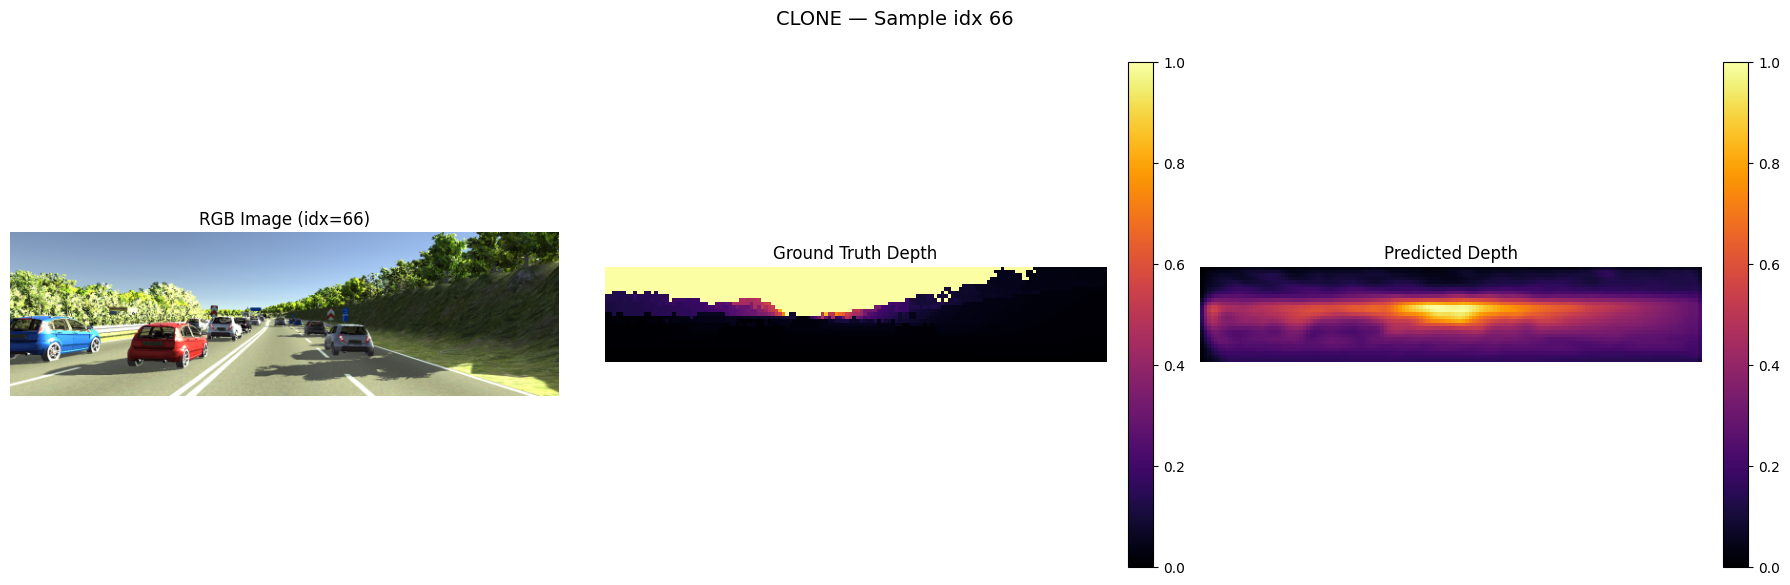

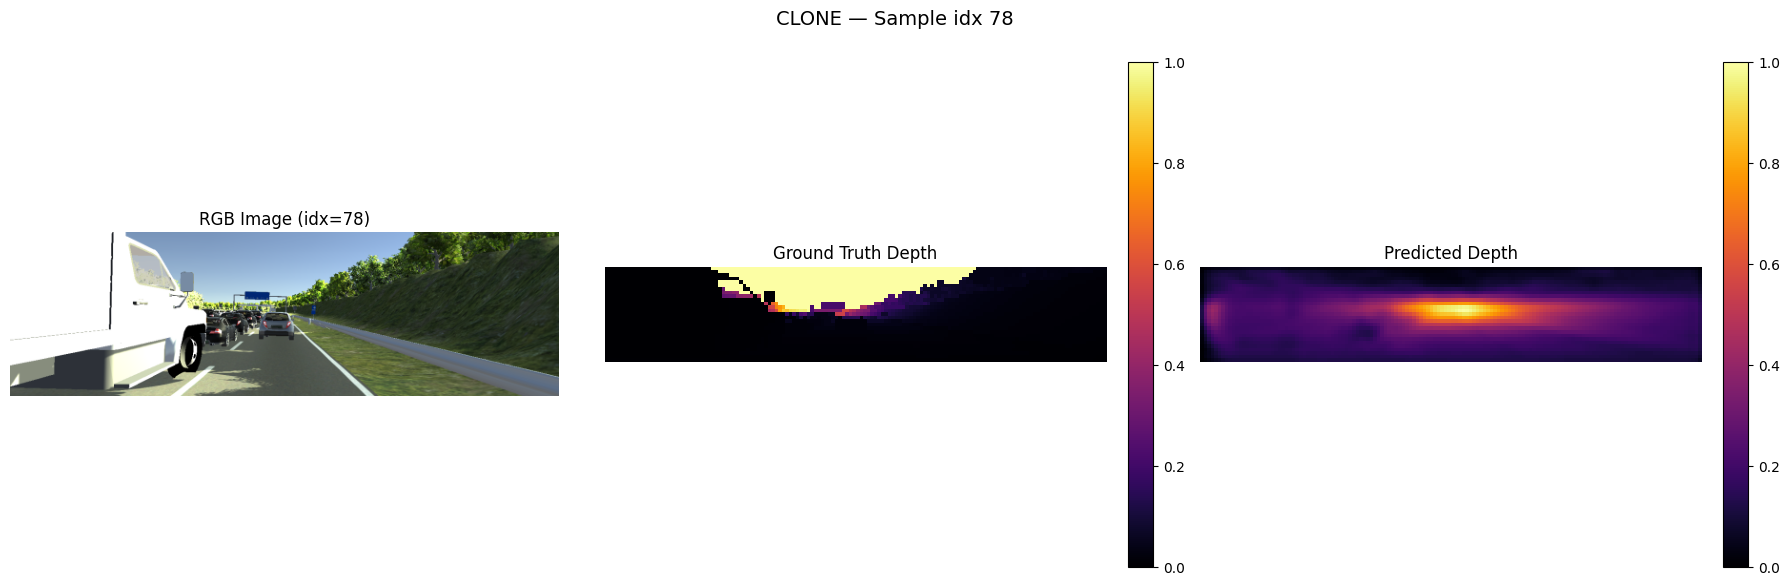

In [ ]:
visualize_condition_samples(
    "clone",
    idx_list=[66, 78],
    cmap="inferno"
)


 Qualitative Results (Selected 2 Samples)



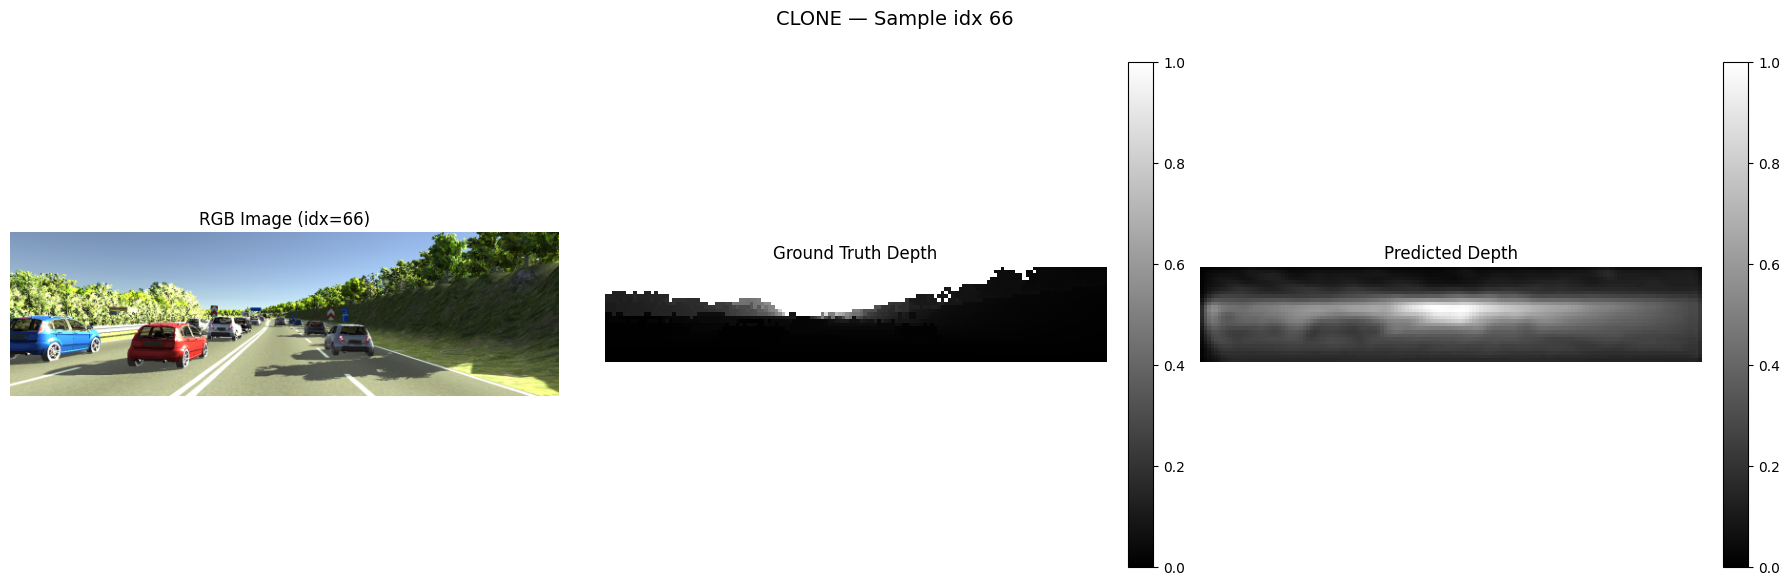

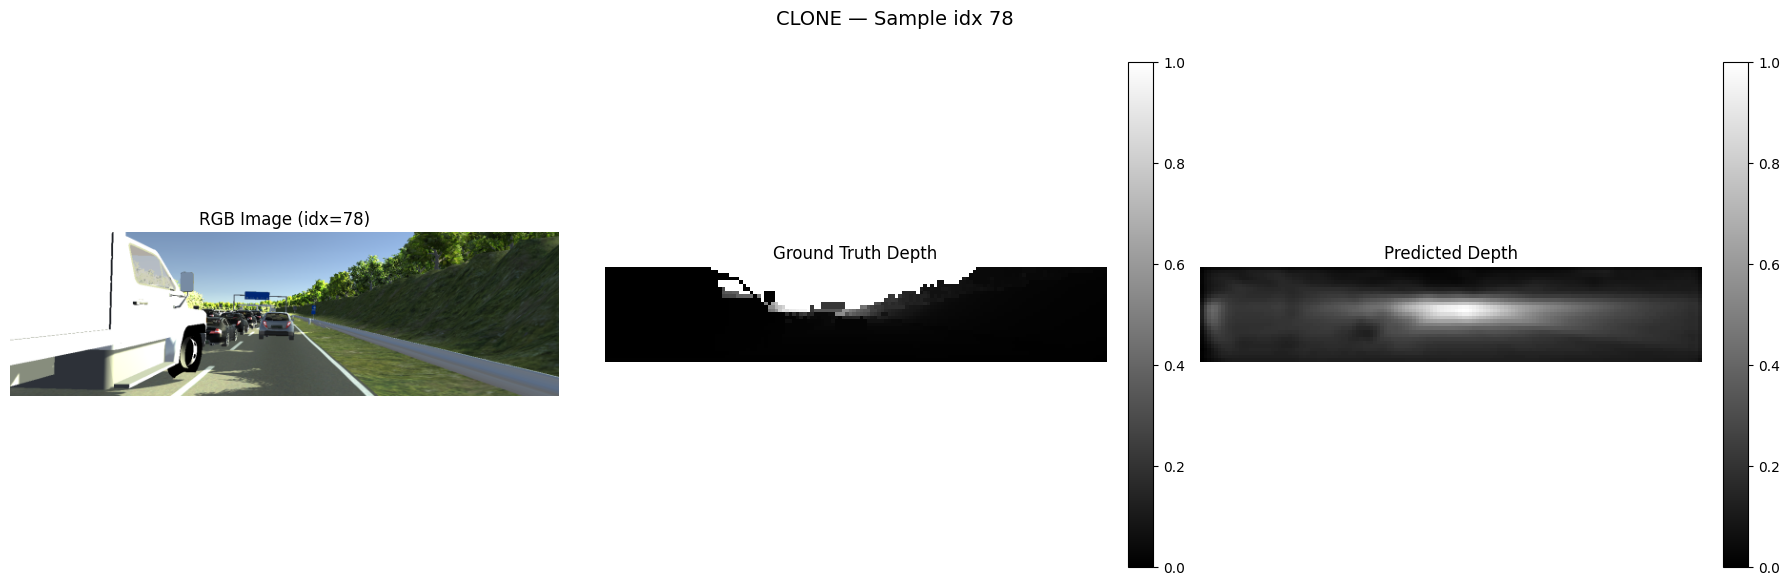

In [ ]:
visualize_condition_samples(
    "clone",
    idx_list=[66, 78],
    cmap="gray"
)

## Condition : Fog

### Performance Metrics

In [ ]:
# ==============================
# Condition: FOG
# ==============================
display_condition_metrics("fog")

 Evaluation Metrics (Mean over all samples)



Value
Abs Rel     0.5718
Sq Rel      8.4579
RMSE       15.9756
RMSElog     0.7946
δ < 1.25    0.2500
δ < 1.25²   0.4924
δ < 1.25³   0.6739

### Sample visualization of RGB Image, Ground Truth, Predicted Depth


 Qualitative Results (Selected 3 Samples)



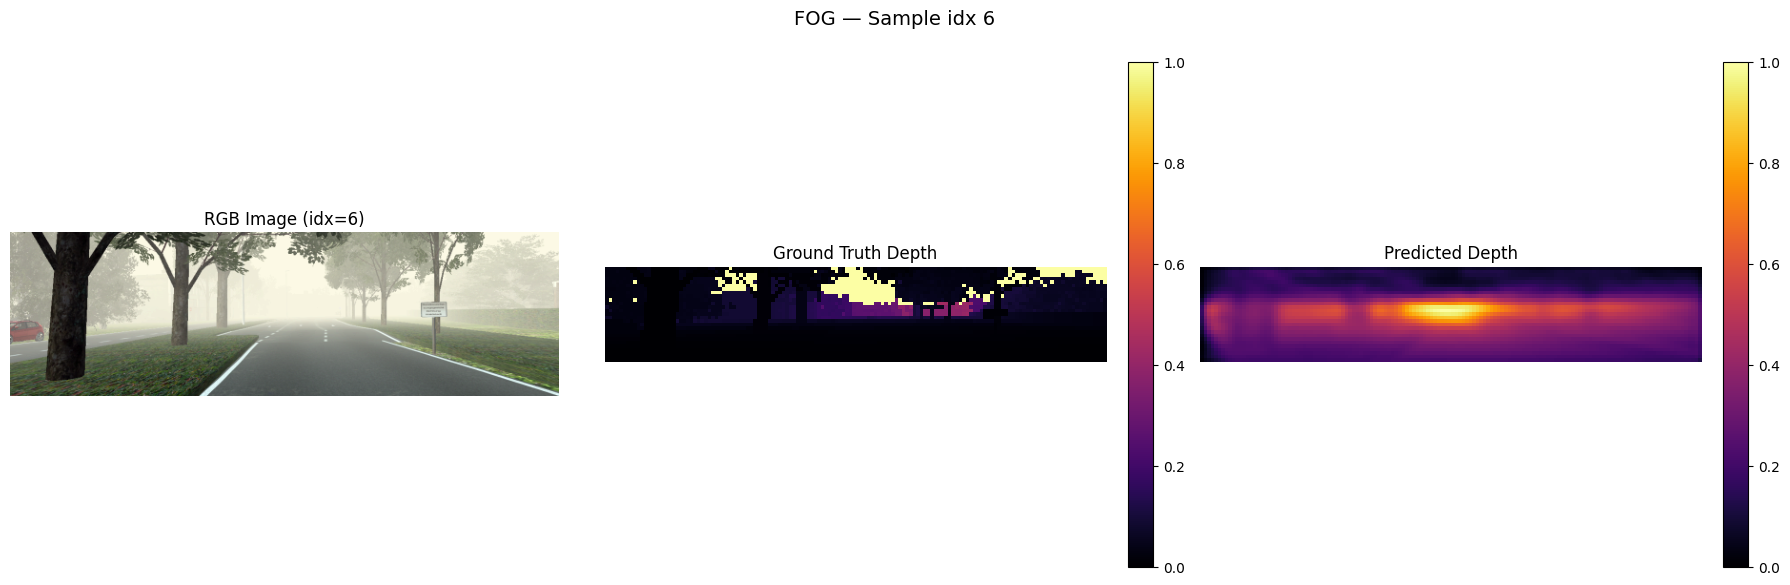

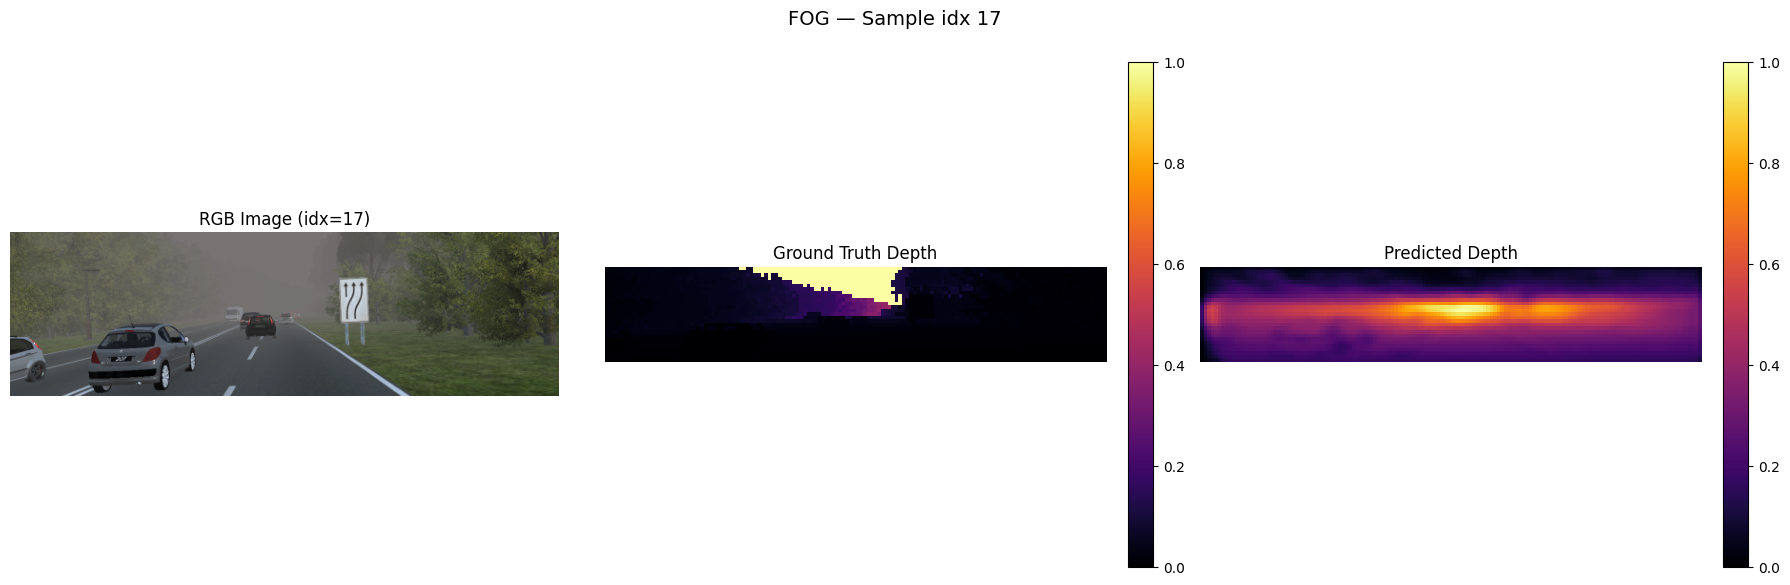

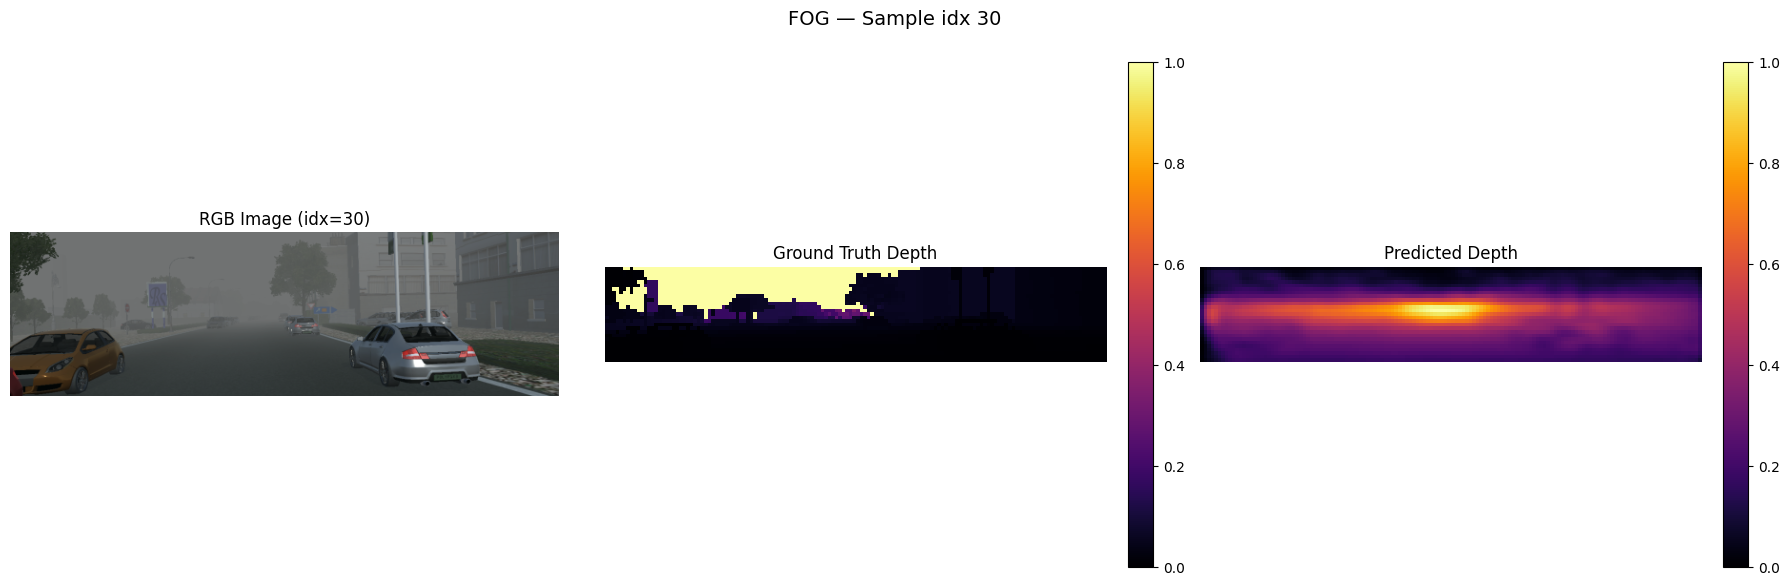

In [ ]:
visualize_condition_samples(
    "fog",
    idx_list=[6, 17, 30],
    cmap="inferno"
)


 Qualitative Results (Selected 3 Samples)



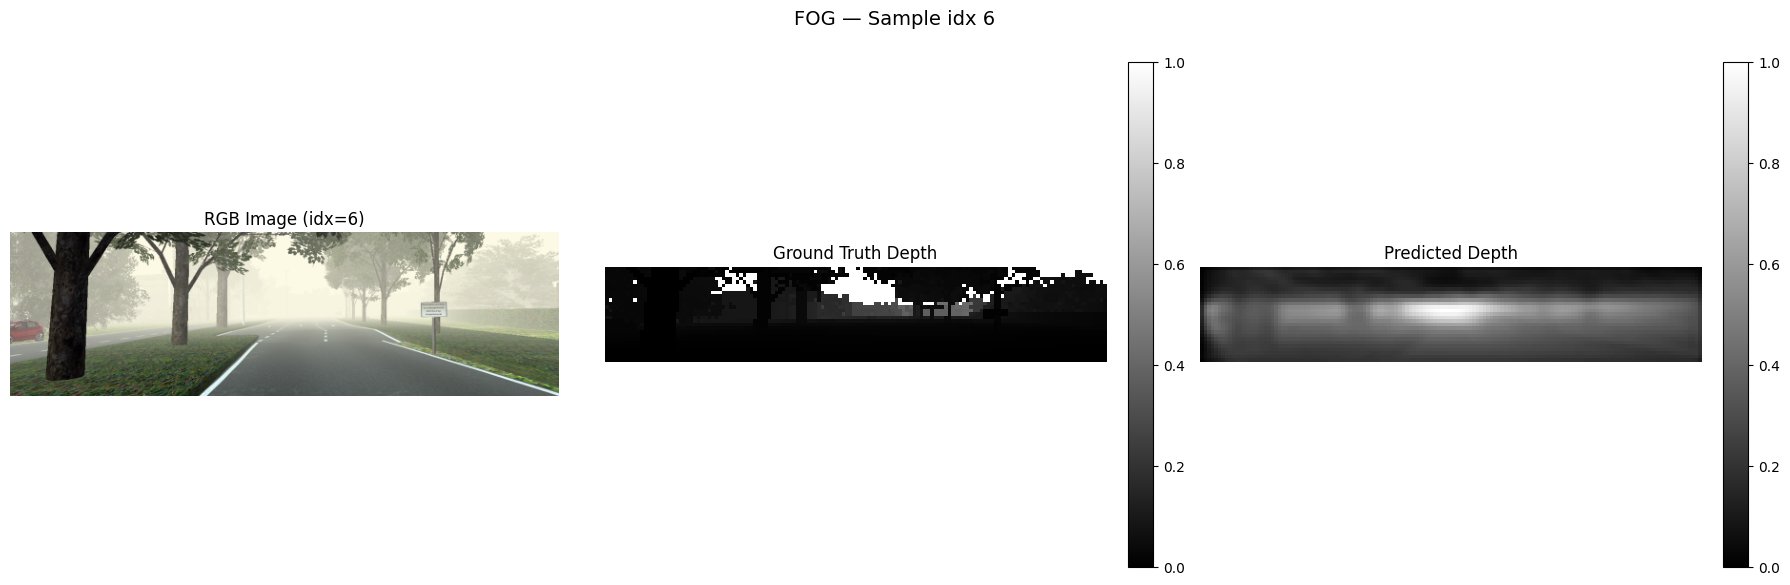

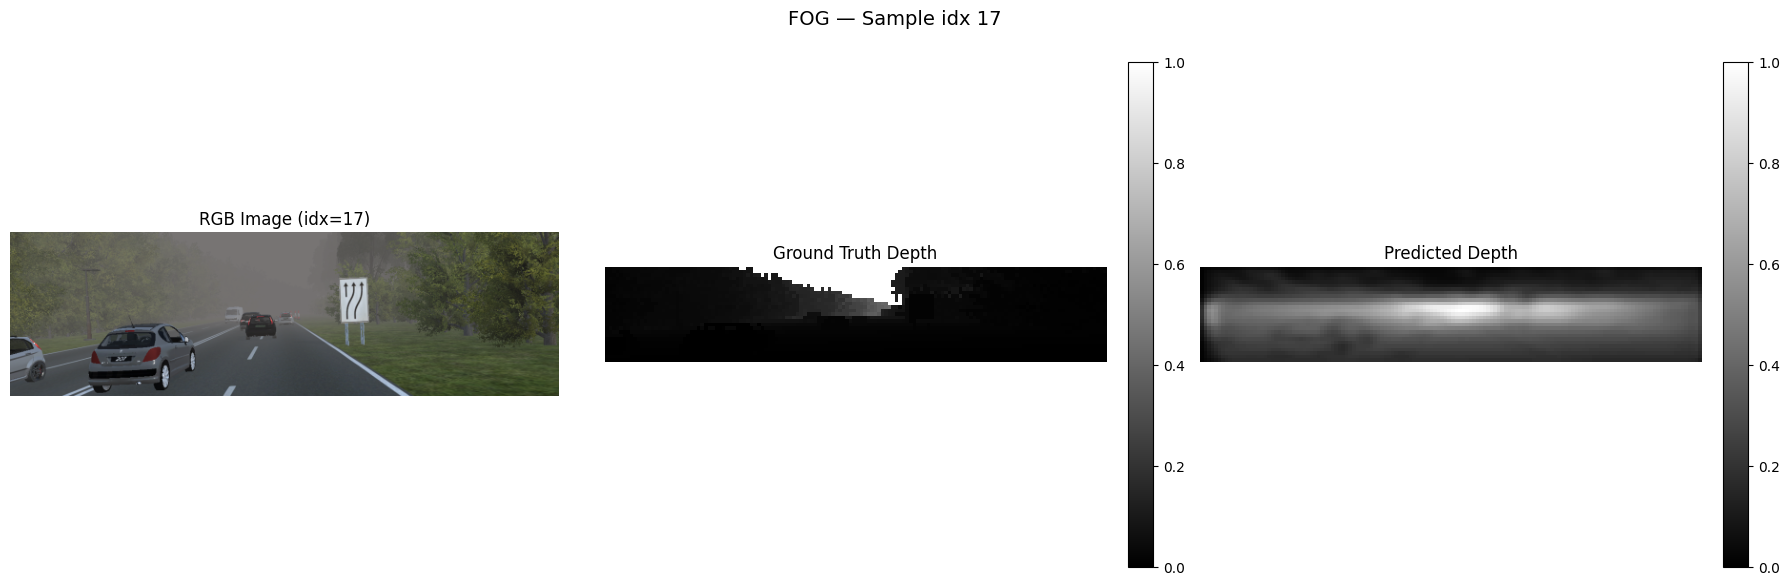

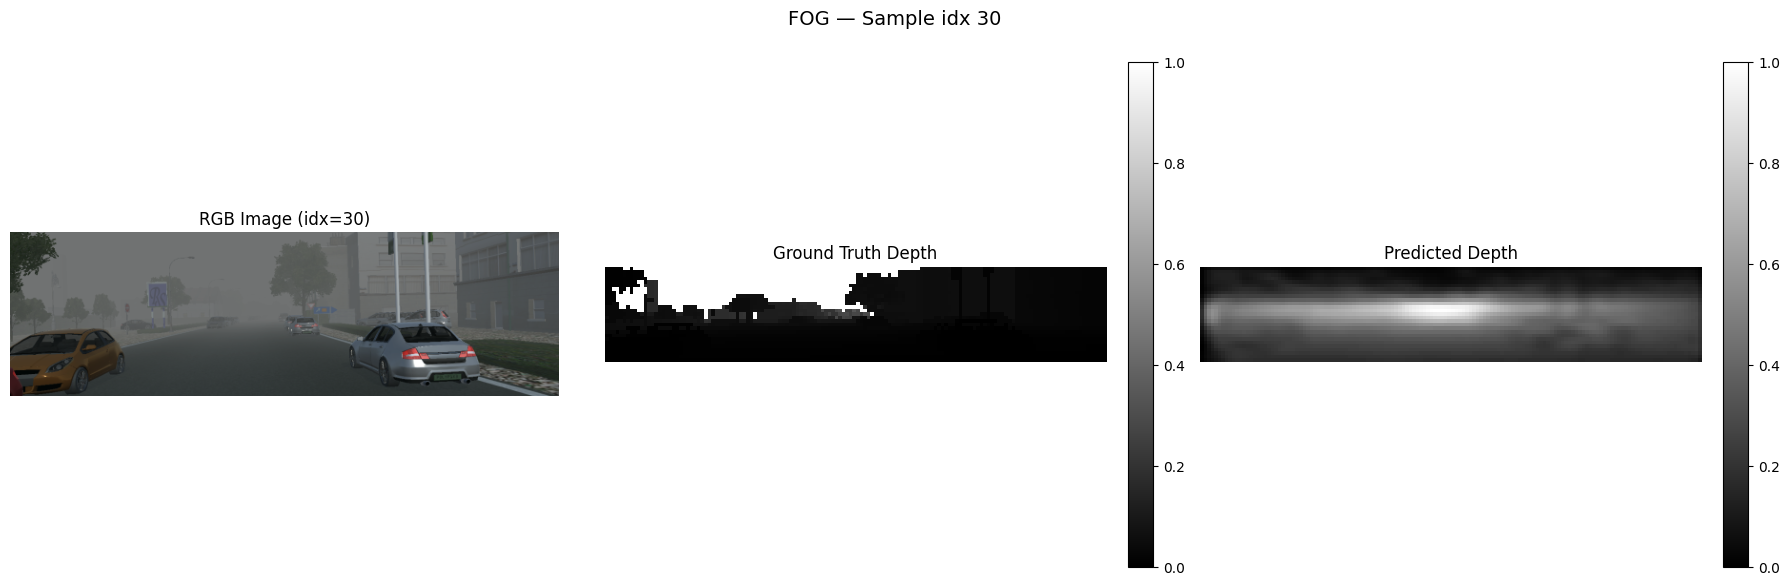

In [ ]:
visualize_condition_samples(
    "fog",
    idx_list=[6, 17, 30],
    cmap="gray"
)

## Condition : Morning

### Performance Metrics

In [ ]:
# ==============================
# Condition: MORNING
# ==============================
display_condition_metrics("morning")

 Evaluation Metrics (Mean over all samples)



Value
Abs Rel     0.5229
Sq Rel      7.5606
RMSE       14.3862
RMSElog     0.6768
δ < 1.25    0.3029
δ < 1.25²   0.5675
δ < 1.25³   0.7361

### Sample visualization of RGB Image, Ground Truth, Predicted Depth


 Qualitative Results (Selected 2 Samples)



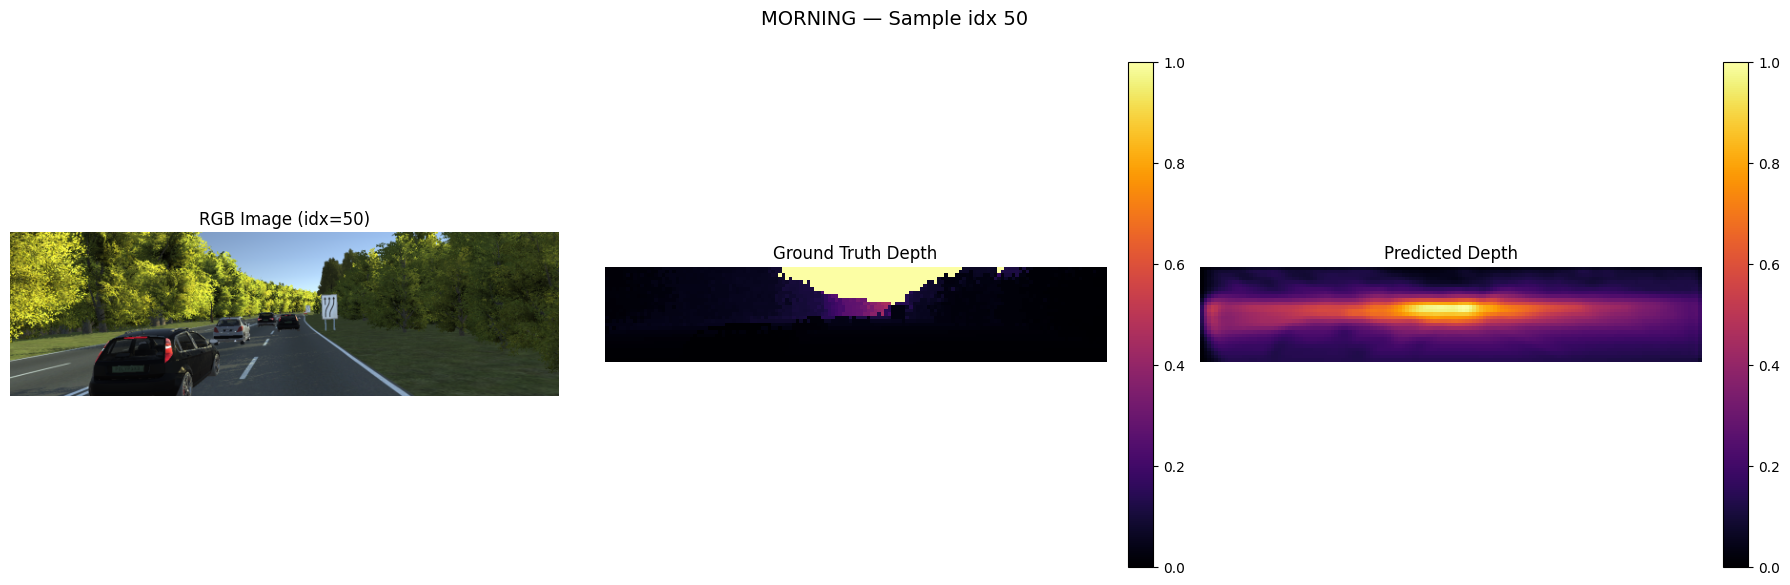

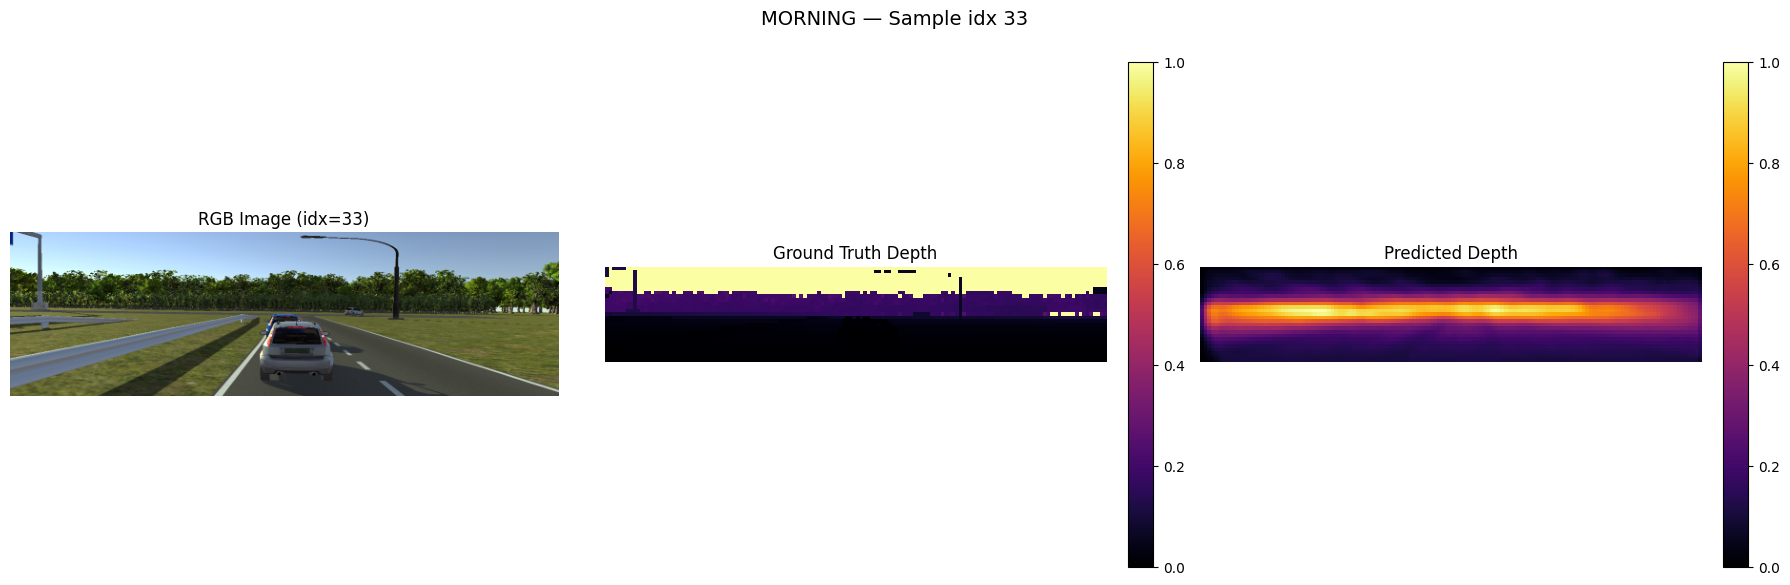

In [ ]:
visualize_condition_samples(
    "morning",
    idx_list=[50, 33],
    cmap="inferno"
)


 Qualitative Results (Selected 2 Samples)



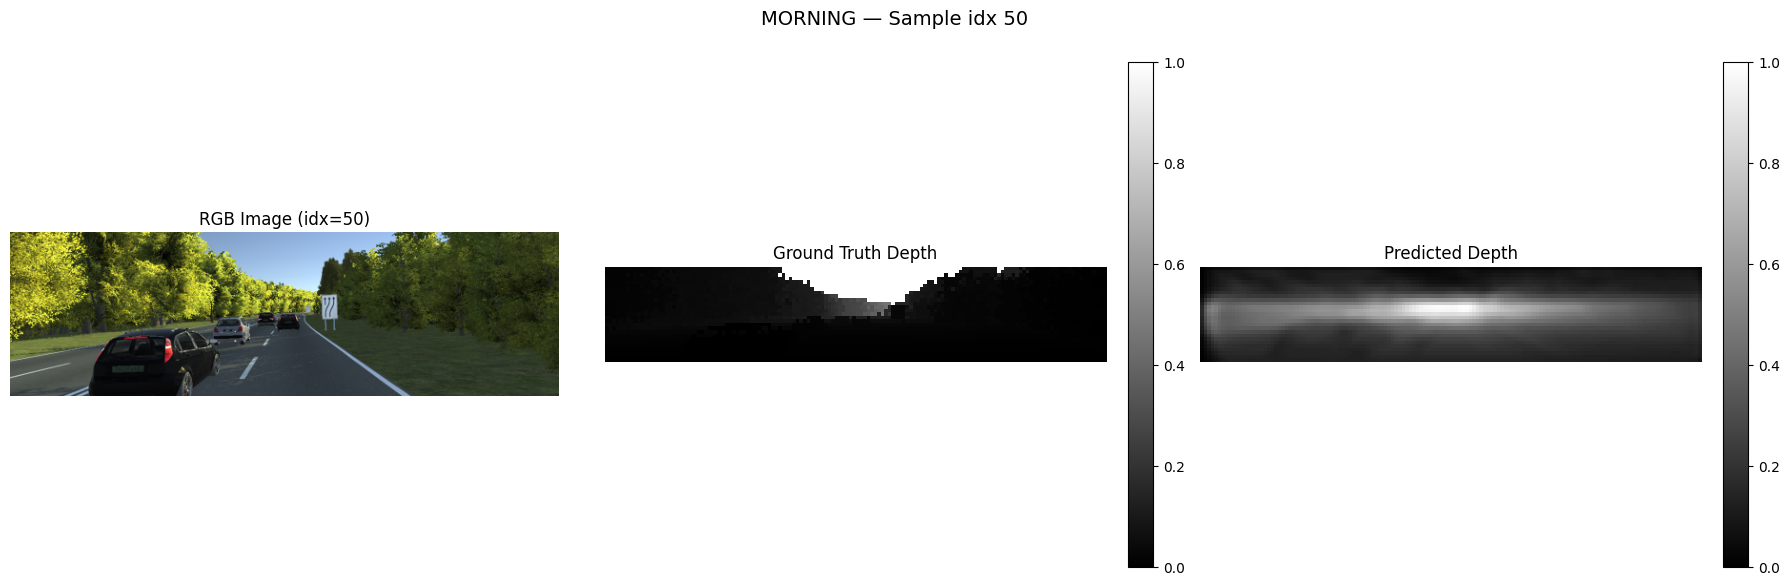

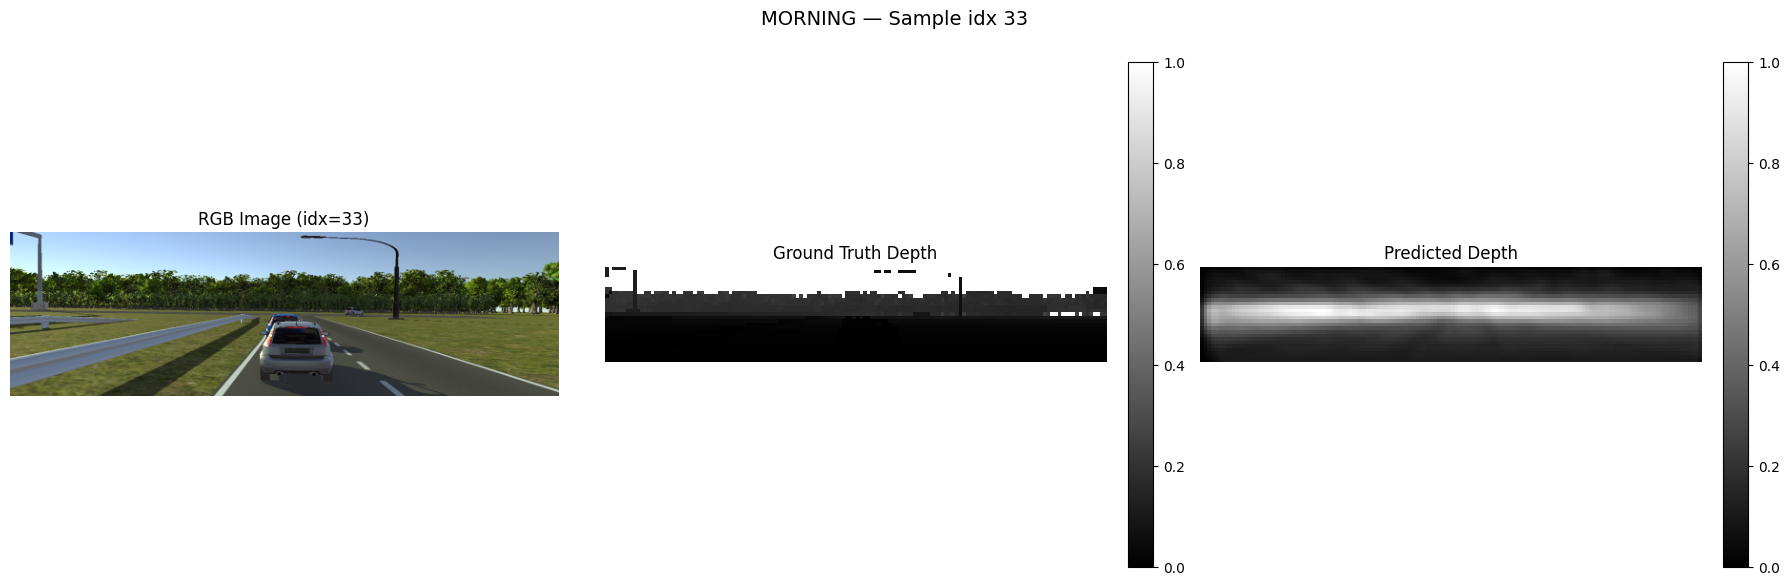

In [ ]:
visualize_condition_samples(
    "morning",
    idx_list=[50, 33],
    cmap="gray"
)

## Condition : Overcast

### Performance Metrics

In [ ]:
# ==============================
# Condition: OVERCAST
# ==============================
display_condition_metrics("overcast")

 Evaluation Metrics (Mean over all samples)



Value
Abs Rel     0.5321
Sq Rel      7.7903
RMSE       14.6906
RMSElog     0.6900
δ < 1.25    0.2939
δ < 1.25²   0.5605
δ < 1.25³   0.7241

### Sample visualization of RGB Image, Ground Truth, Predicted Depth


 Qualitative Results (Selected 2 Samples)



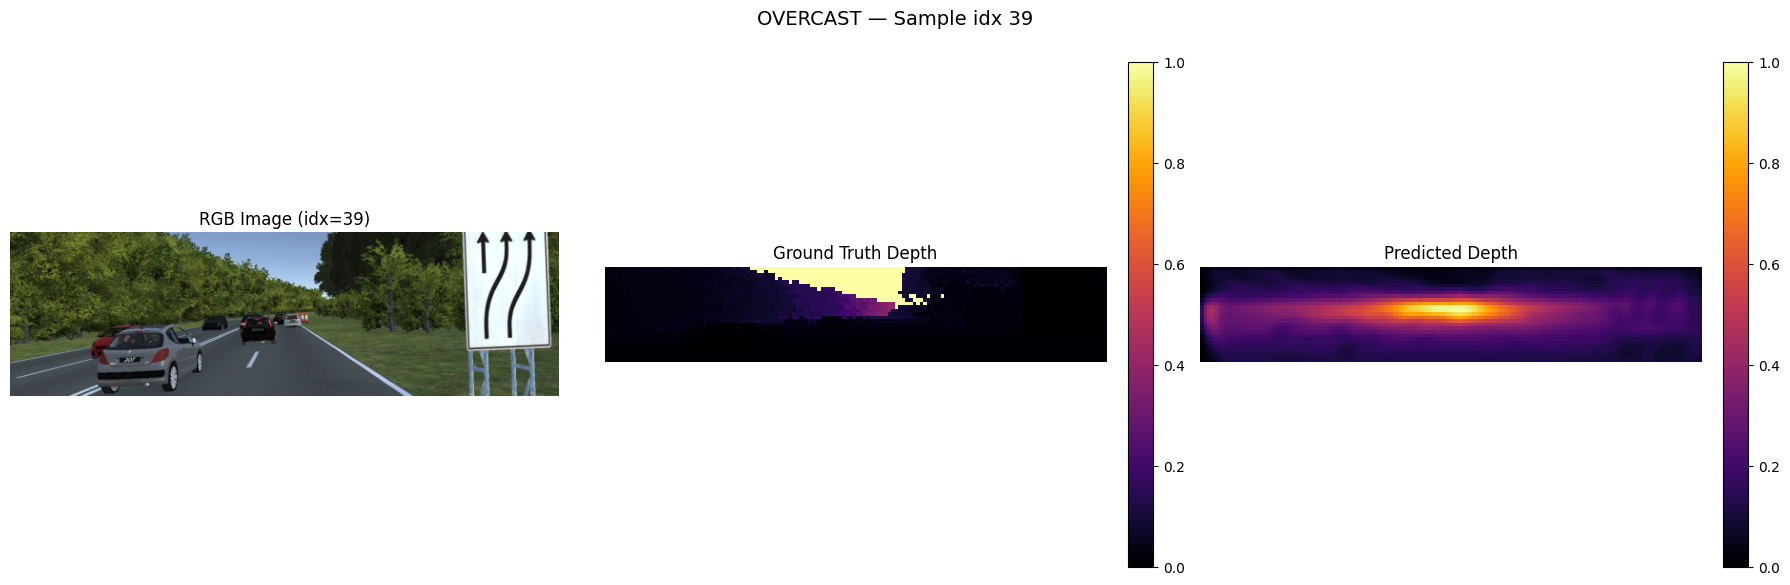

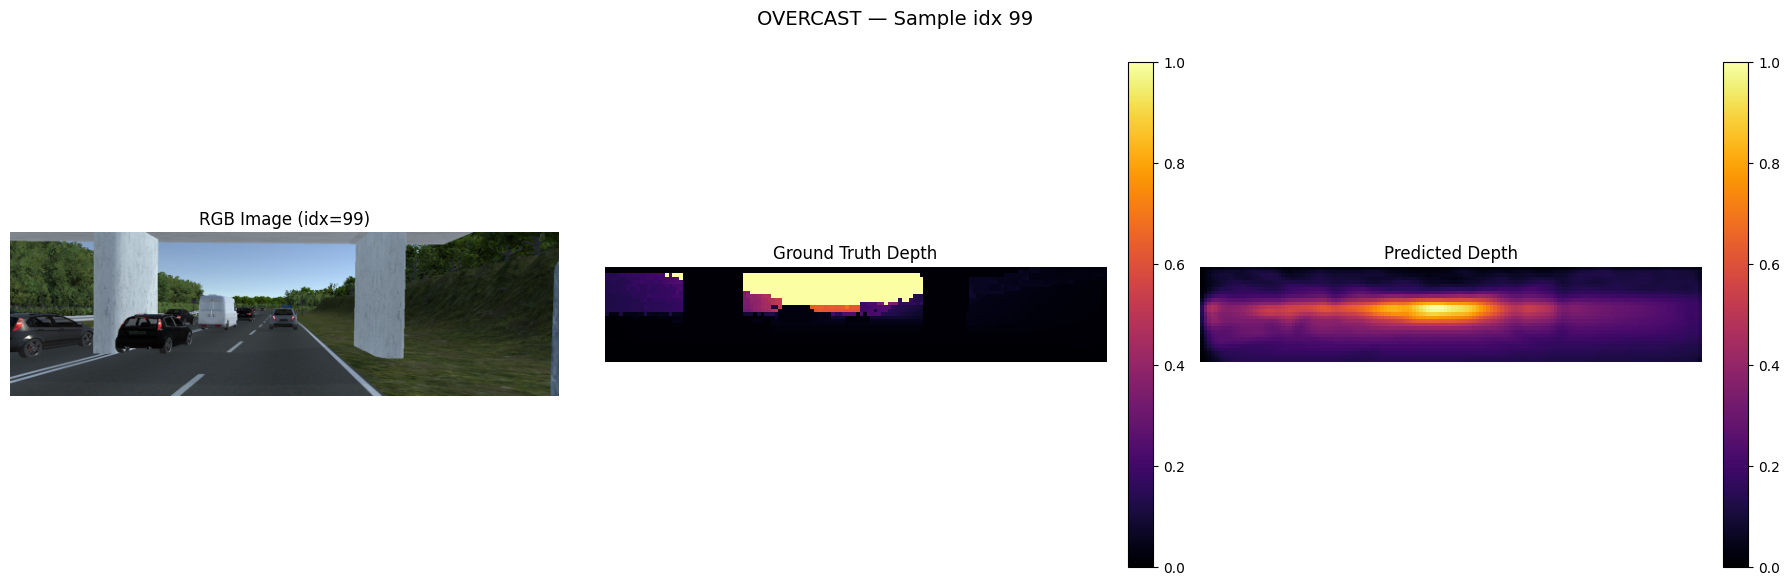

In [ ]:
visualize_condition_samples(
    "overcast",
    idx_list=[39, 99],
    cmap="inferno"
)


 Qualitative Results (Selected 2 Samples)



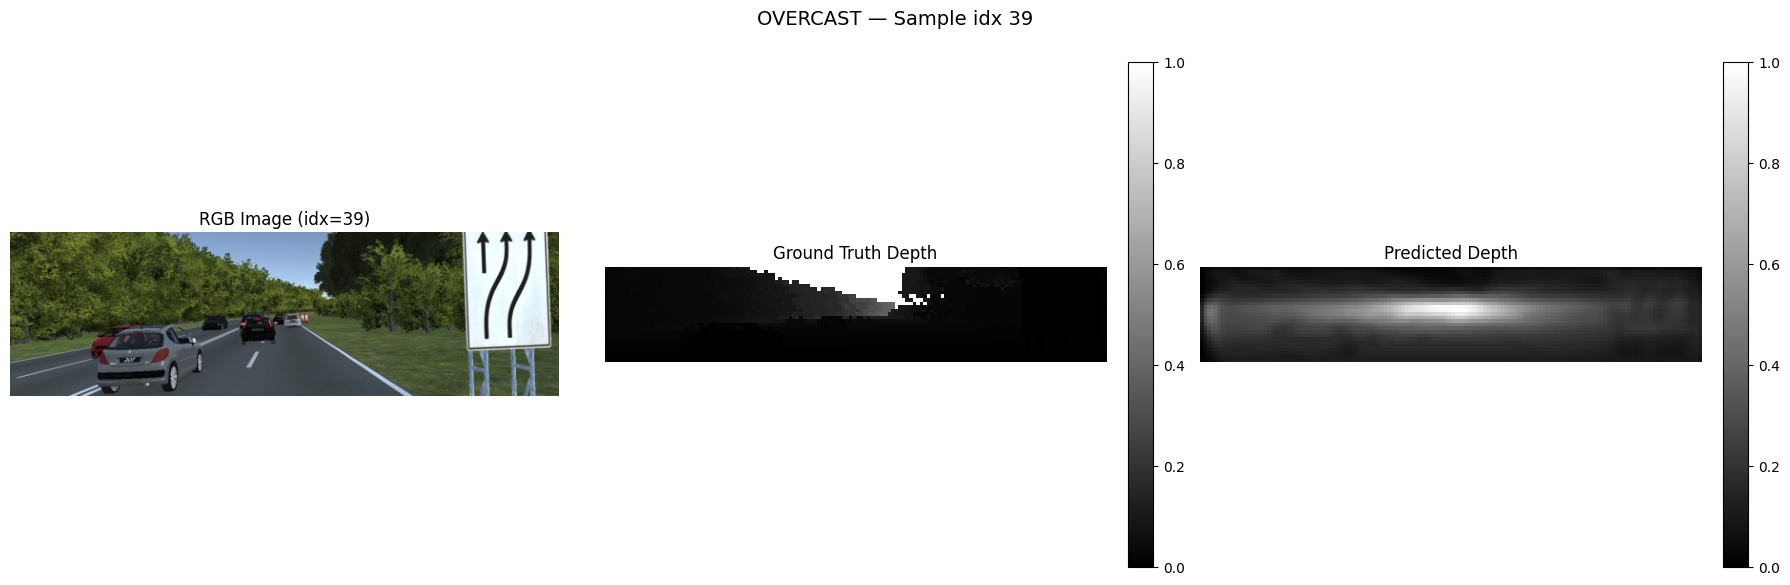

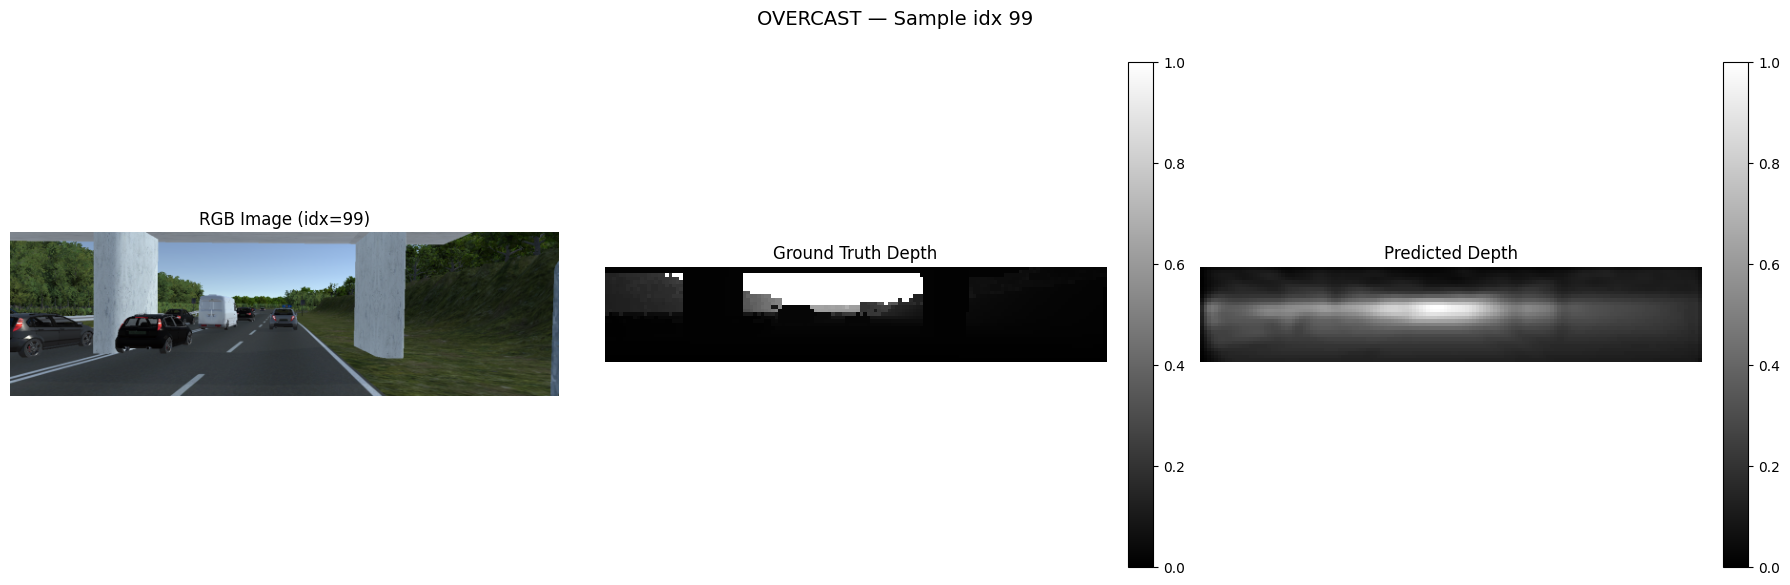

In [ ]:
visualize_condition_samples(
    "overcast",
    idx_list=[39, 99],
    cmap="gray"
)

## Condition : Rain

### Performance Metrics

In [ ]:
# ==============================
# Condition: RAIN
# ==============================
display_condition_metrics("rain")

 Evaluation Metrics (Mean over all samples)



Value
Abs Rel     0.5602
Sq Rel      8.2520
RMSE       15.6354
RMSElog     0.7534
δ < 1.25    0.2610
δ < 1.25²   0.5072
δ < 1.25³   0.6885

### Sample visualization of RGB Image, Ground Truth, Predicted Depth


 Qualitative Results (Selected 2 Samples)



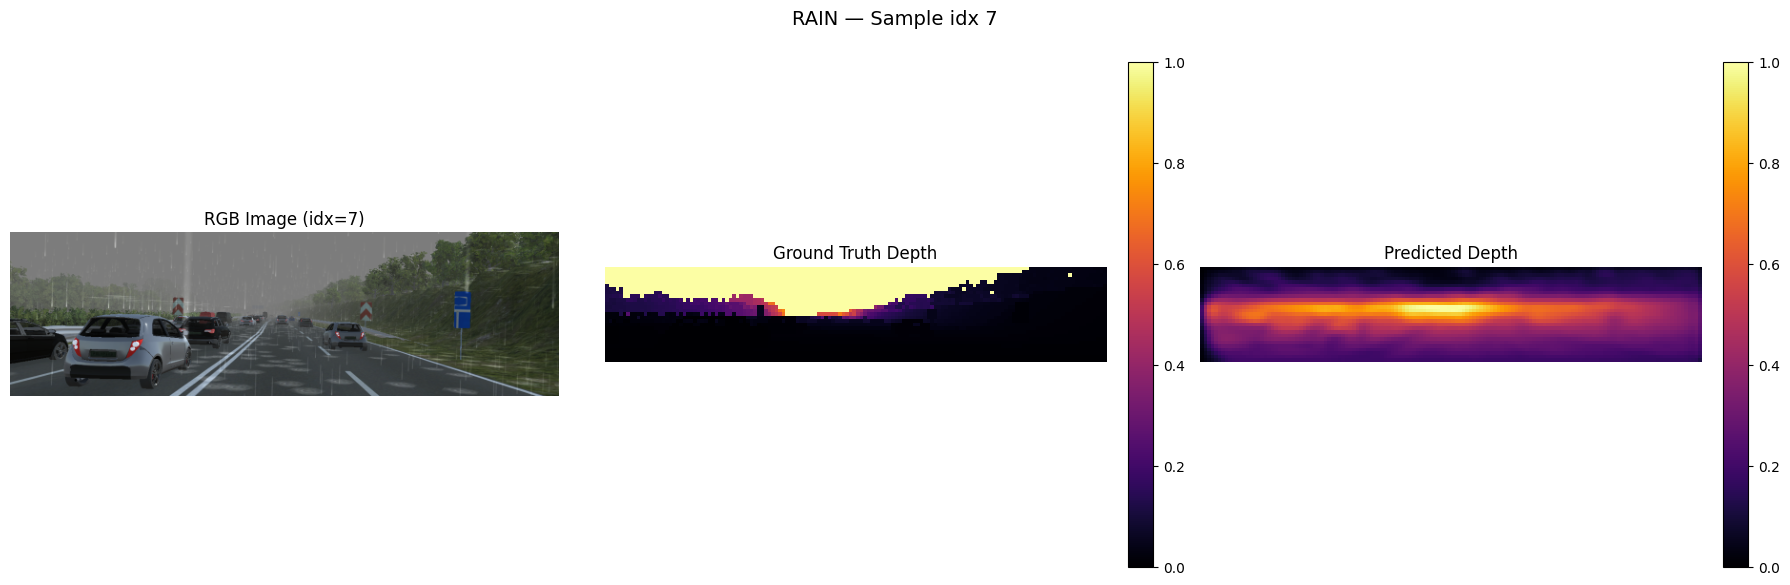

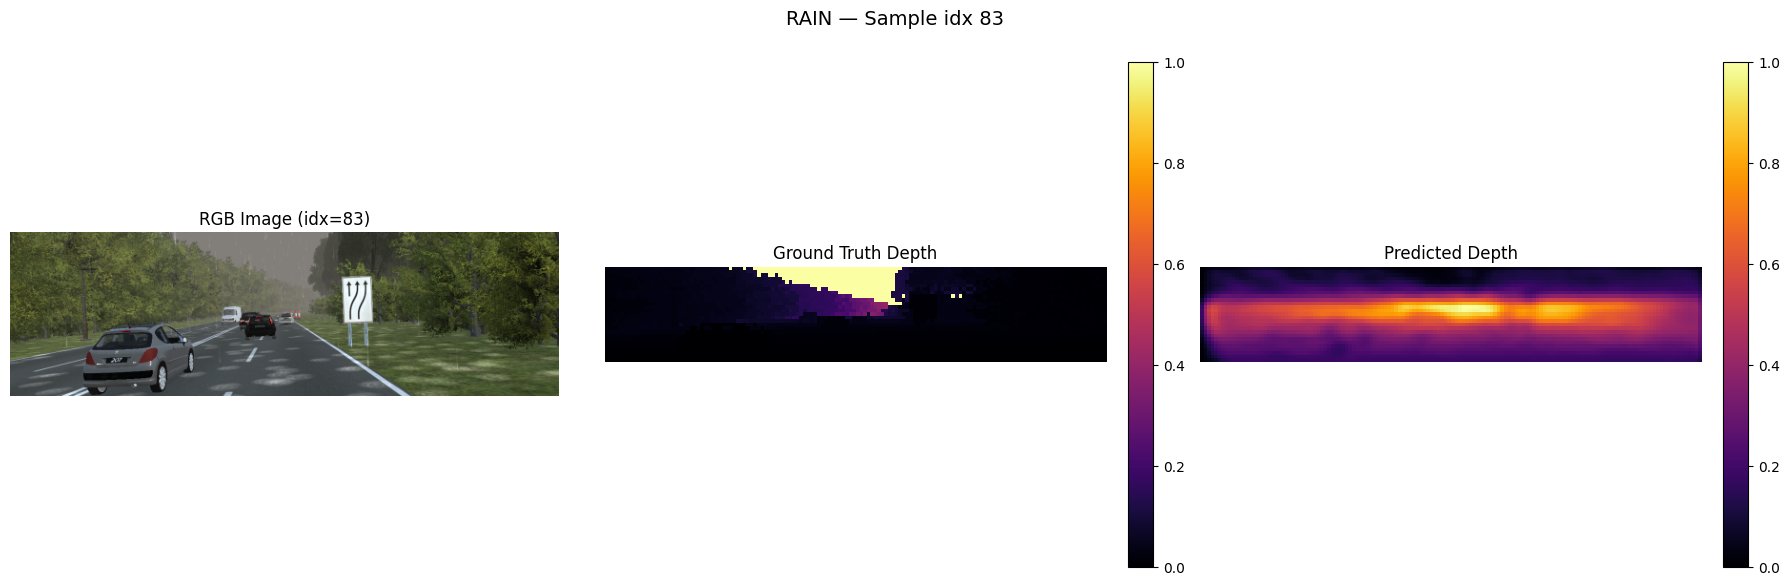

In [4]:
visualize_condition_samples(
    "rain",
    idx_list=[7, 83],
    cmap="inferno"
)


 Qualitative Results (Selected 2 Samples)



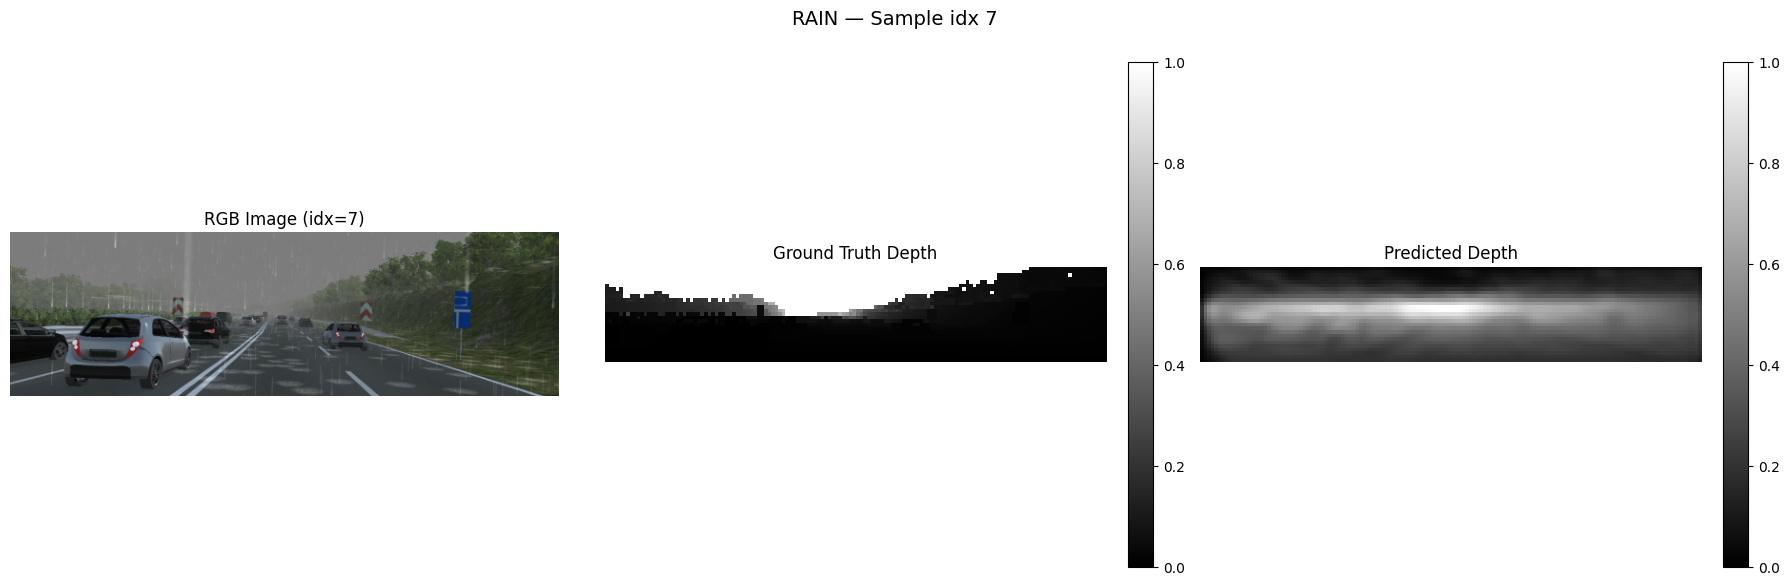

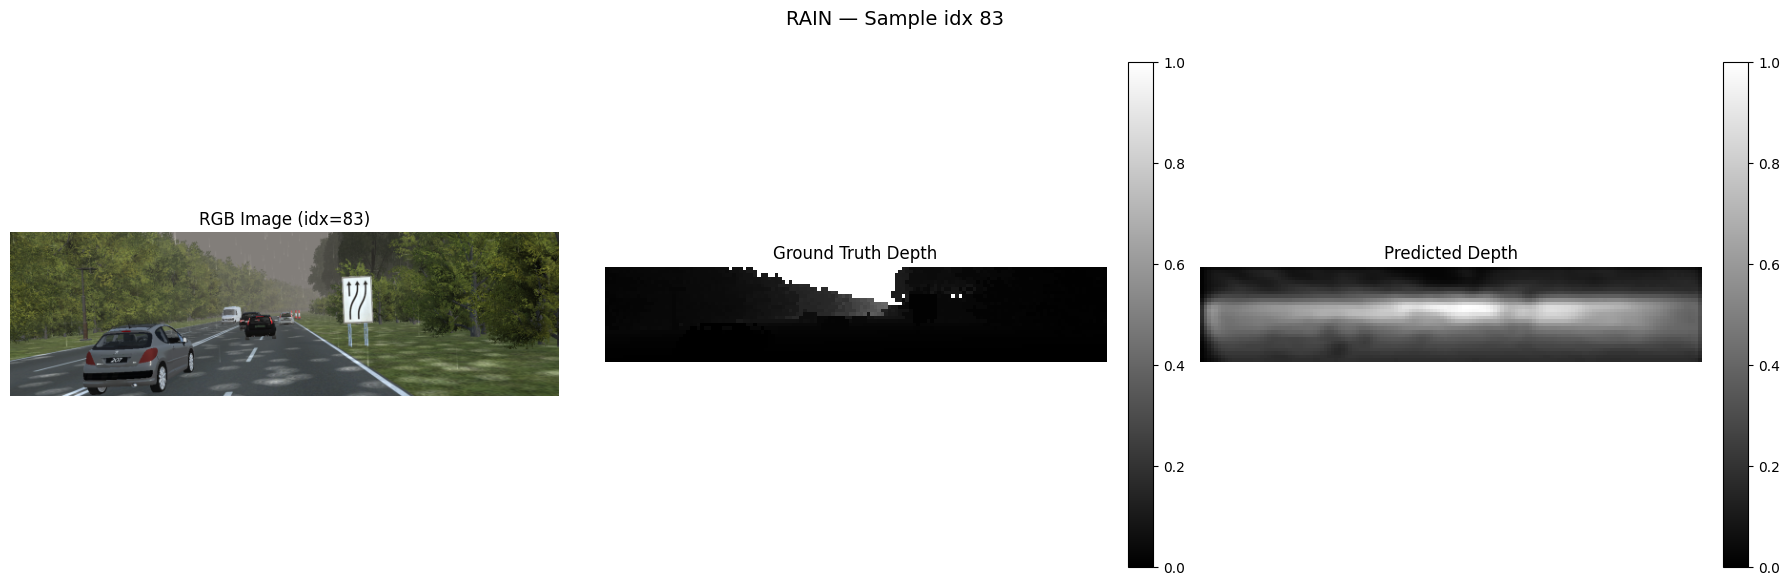

In [ ]:
visualize_condition_samples(
    "rain",
    idx_list=[7, 83],
    cmap="gray"
)

## Condition : Sunset

### Performance Metrics

In [ ]:
# ==============================
# Condition: SUNSET
# ==============================
display_condition_metrics("sunset")

 Evaluation Metrics (Mean over all samples)



Value
Abs Rel     0.5435
Sq Rel      7.8443
RMSE       14.7058
RMSElog     0.6814
δ < 1.25    0.2777
δ < 1.25²   0.5393
δ < 1.25³   0.7217

### Sample visualization of RGB Image, Ground Truth, Predicted Depth


 Qualitative Results (Selected 2 Samples)



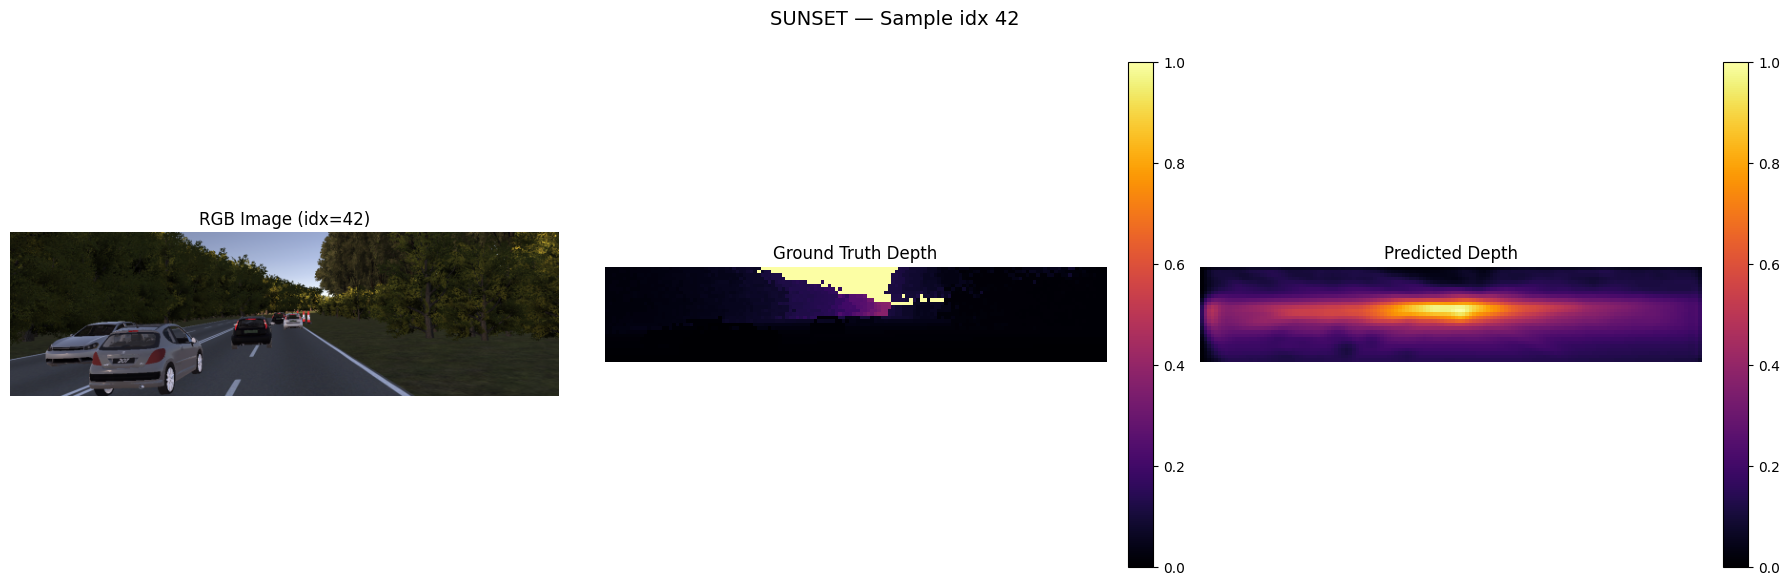

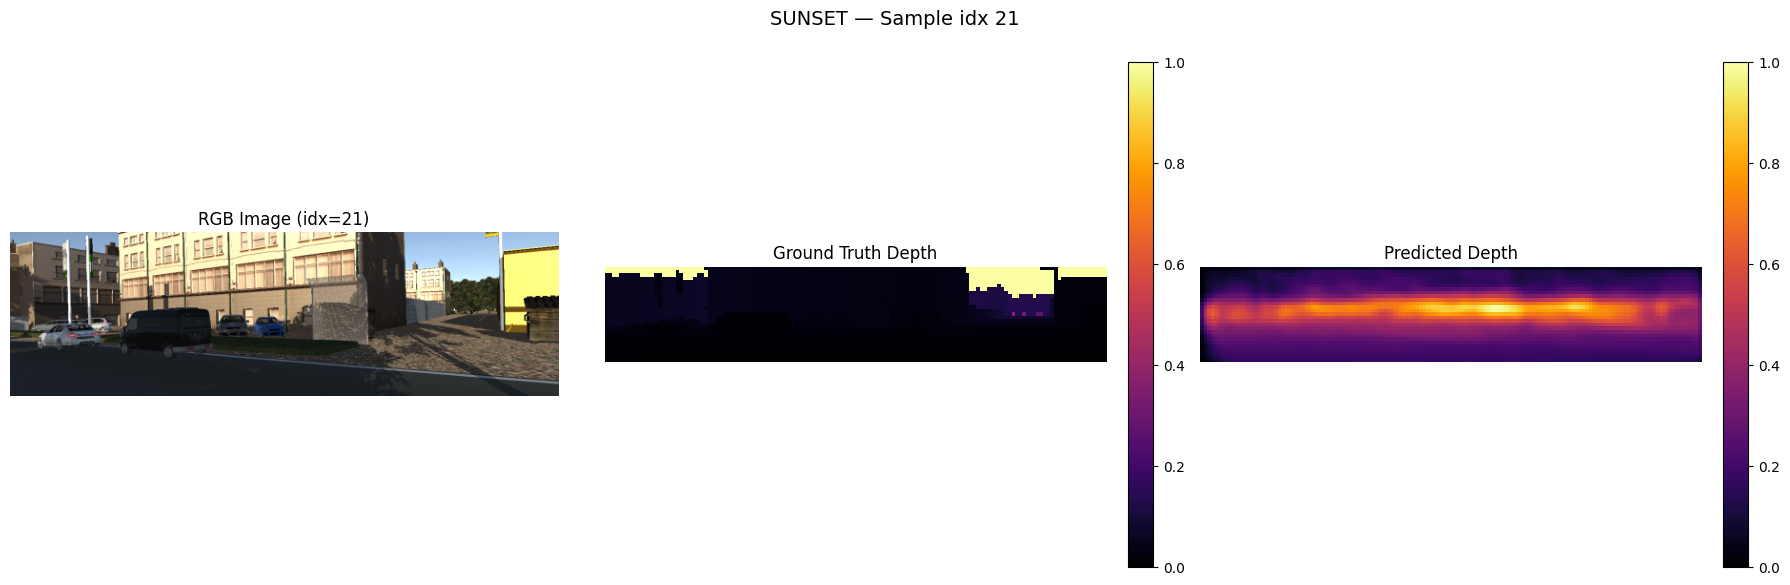

In [ ]:
visualize_condition_samples(
    "sunset",
    idx_list=[42, 21],
    cmap="inferno"
)


 Qualitative Results (Selected 2 Samples)



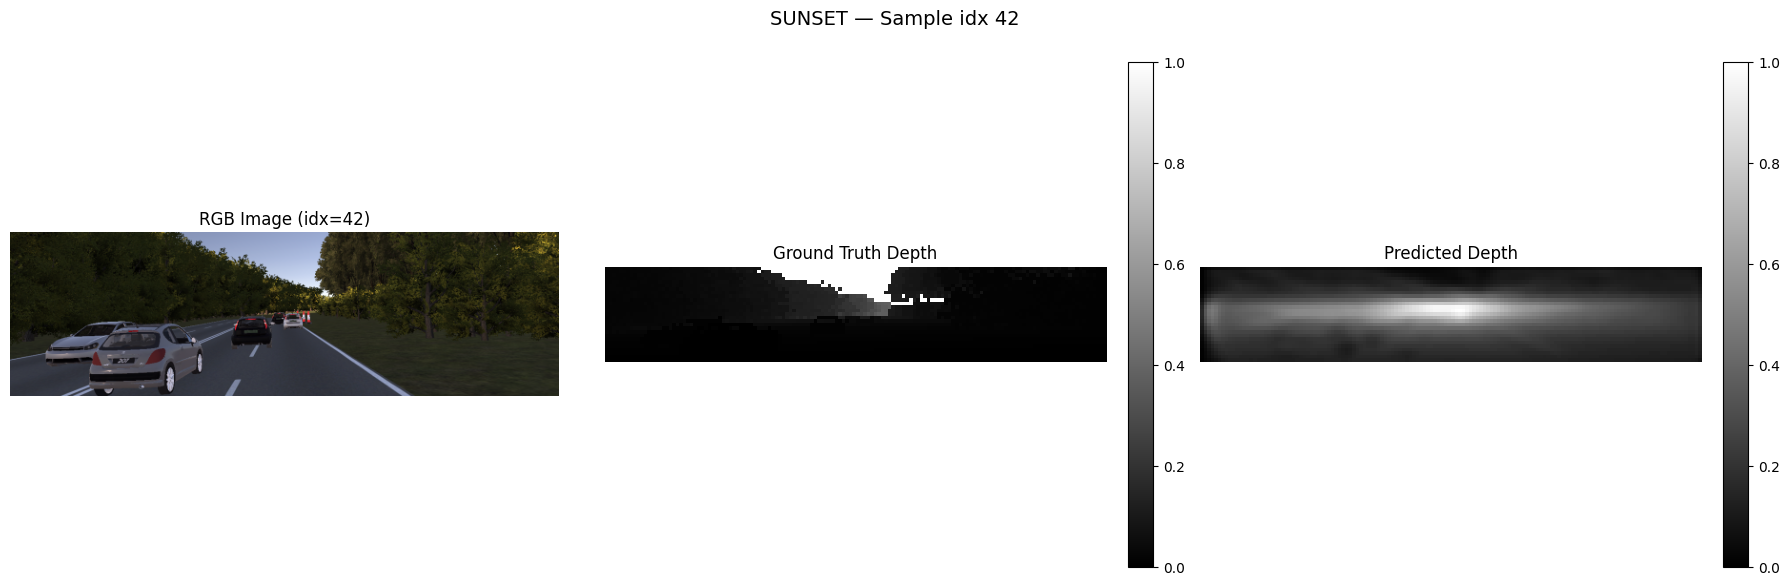

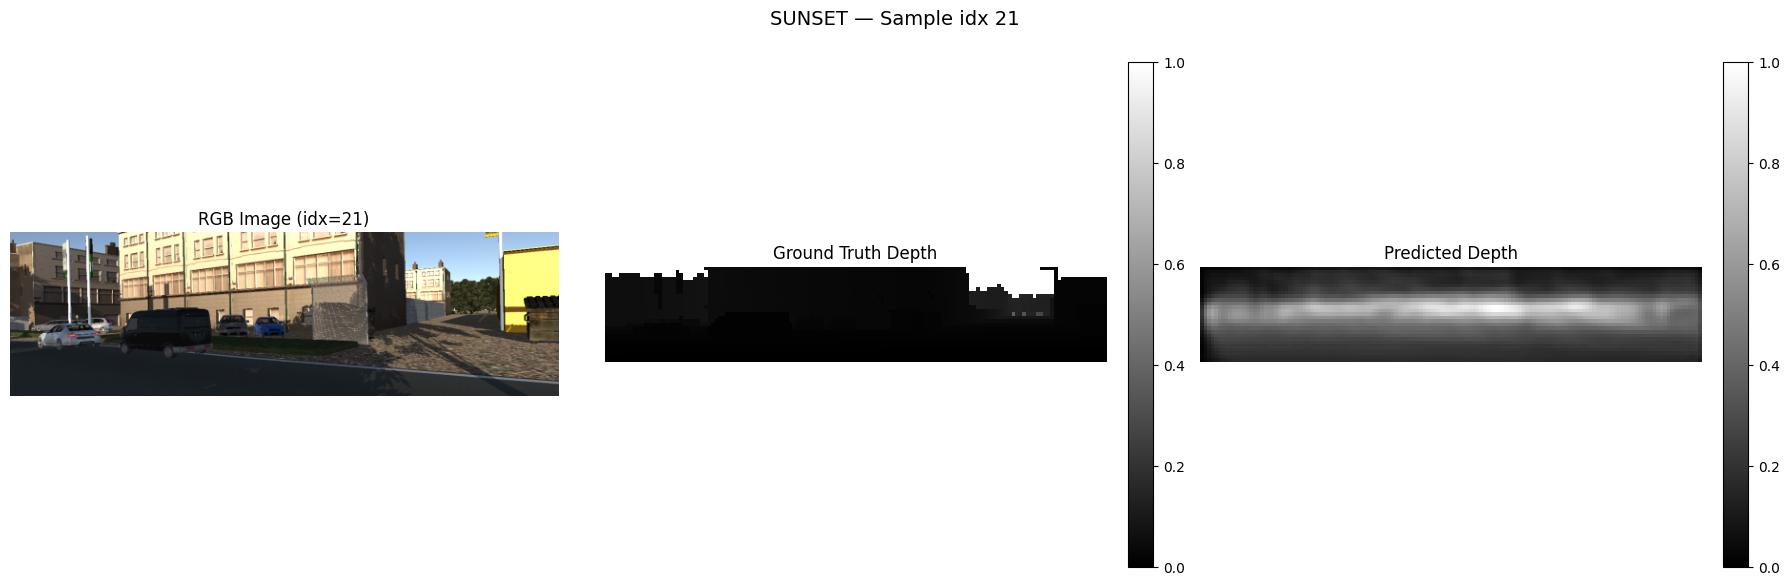

In [ ]:
visualize_condition_samples(
    "sunset",
    idx_list=[42, 21],
    cmap="gray"
)

## Overall Evaluation

In [ ]:
import pandas as pd
from pathlib import Path

# Paths + Conditions
METRICS_ROOT = Path(
    "/content/drive/MyDrive/kitti/EigenNetwork_2014/VKITTI_Benchmark_data/metrics_data/"
)

TARGET_CONDITIONS = ["clone", "fog", "morning", "overcast", "rain", "sunset"]

RECORD_COUNT = 2126  # constant number of samples per condition

rows = []

for cond in TARGET_CONDITIONS:
    df = pd.read_csv(METRICS_ROOT / f"{cond}_metrics.csv")

    rows.append({
        "Condition": cond,
        "Record count": RECORD_COUNT,

        # Accuracy (delta metrics)
        "δ < 1.25":  df["delta1"].mean(),
        "δ < 1.25²": df["delta2"].mean(),
        "δ < 1.25³": df["delta3"].mean(),

        # Error metrics
        "Abs Rel":   df["abs_rel"].mean(),
        "Sq Rel":    df["sq_rel"].mean(),
        "RMSE":      df["rmse"].mean(),
        "RMSElog":   df["rmse_log"].mean(),
        "SILog":     df["silog"].mean(),
    })

final_metrics_df = (
    pd.DataFrame(rows)
    .set_index("Condition")
    .round(4)
)

print(" Final Evaluation Metrics Across All Conditions\n")
display(final_metrics_df)


 Final Evaluation Metrics Across All Conditions



Record count  δ < 1.25  δ < 1.25²  δ < 1.25³  Abs Rel  Sq Rel  \
Condition                                                                  
clone              2126    0.3043     0.5806     0.7547   0.5085  7.6954   
fog                2126    0.2500     0.4924     0.6739   0.5718  8.4579   
morning            2126    0.3029     0.5675     0.7361   0.5229  7.5606   
overcast           2126    0.2939     0.5605     0.7241   0.5321  7.7903   
rain               2126    0.2610     0.5072     0.6885   0.5602  8.2520   
sunset             2126    0.2777     0.5393     0.7217   0.5435  7.8443   

              RMSE  RMSElog   SILog  
Condition                            
clone      14.6812   0.6832  0.6736  
fog        15.9756   0.7946  0.7847  
morning    14.3862   0.6768  0.6692  
overcast   14.6906   0.6900  0.6823  
rain       15.6354   0.7534  0.7447  
sunset     14.7058   0.6814  0.6736

## Relative Performance Change

In [ ]:
baseline = final_metrics_df.loc["clone"]

delta_df = final_metrics_df.copy()

for col in final_metrics_df.columns:
    delta_df[col] = (
        (final_metrics_df[col] - baseline[col]) / baseline[col]
    ) * 100

delta_df = delta_df.round(2)
display(delta_df)

Record count  δ < 1.25  δ < 1.25²  δ < 1.25³  Abs Rel  Sq Rel  \
Condition                                                                  
clone               0.0      0.00       0.00       0.00     0.00    0.00   
fog                 0.0    -17.84     -15.19     -10.71    12.45    9.91   
morning             0.0     -0.46      -2.26      -2.46     2.83   -1.75   
overcast            0.0     -3.42      -3.46      -4.05     4.64    1.23   
rain                0.0    -14.23     -12.64      -8.77    10.17    7.23   
sunset              0.0     -8.74      -7.11      -4.37     6.88    1.93   

           RMSE  RMSElog  SILog  
Condition                        
clone      0.00     0.00   0.00  
fog        8.82    16.31  16.49  
morning   -2.01    -0.94  -0.65  
overcast   0.06     1.00   1.29  
rain       6.50    10.28  10.56  
sunset     0.17    -0.26   0.00